Social Data Analysis and Visualization - Final Project

Vasiliki Tsanaktsidou s232489, 

Rita Marti Tora s232935

1. MOTIVATION

*- What is your dataset?*

We used a comprehensive dataset of Airbnb listings and calendars for eight major European cities (Amsterdam, Athens, Barcelona, Madrid, Paris, Prague, Vienna, and London). This dataset includes detailed information on:

Listings: Property details, host information, location, amenities, and review scores.

Reviews: User feedback on the properties.

Calendar: Availability and pricing data for each property over a specified period (June2024 - June2025).

The data was obtained from publicly available sources and cleaned for accuracy and consistency.



*-Why did you choose this/these particular dataset(s)?*


We chose these cities because they are popular tourist destinations in Europe, each with a unique mix of local regulations regarding short-term rentals. This diversity allows us to explore how Airbnb operates in different environments—ranging from heavily regulated markets like Amsterdam to more relaxed ones like Athens. The inclusion of calendar data also enables us to analyze seasonal trends and occupancy dynamics.

*-What was your goal for the end user's experience?*

Our goal was to create an intuitive, informative, and interactive platform for users to explore and understand the Airbnb market in eight major European cities. 

Our visualizations were designed to make complex data easily understandable. Users could quickly grasp key insights about prices, occupancy rates, host types, and market concentration across cities.

We utilized interactive Bokeh visualizations, allowing users to explore occupancy rates over time, filter by cities, and engage with the data dynamically. This enhanced user engagement and understanding.

The platform allowed users to easily compare different cities across multiple dimensions, such as price distribution, occupancy trends, and host characteristics, helping them identify patterns and differences.

The visual layout was designed to be clean and intuitive, ensuring that even users without a data background could easily navigate and understand the insights.

Whether for tourists, Airbnb hosts, or policymakers, the platform provided actionable insights. Tourists could use it to identify affordable cities, hosts could understand market dynamics, and policymakers could monitor market concentration.



2. BASIC STATS

In [ ]:
import os
import gzip
import shutil
import requests
from urllib.parse import urljoin

# Configuration
BASE_URL = "https://data.insideairbnb.com/austria/vienna/vienna/2024-06-15/data/"
VISUALISATIONS_URL = "https://data.insideairbnb.com/austria/vienna/vienna/2024-06-15/visualisations/"

FILES = [
    {"name": "listings.csv.gz", "url": BASE_URL},
    {"name": "reviews.csv", "url": BASE_URL},
    {"name": "calendar.csv.gz", "url": BASE_URL},
    {"name": "neighbourhoods.csv", "url": VISUALISATIONS_URL}
]

# Create output directory
parent_dir = "Airbnb_June2024_June2025"  # Replace with actual parent directory name
output_dir = os.path.join(parent_dir, "Vienna")
os.makedirs(output_dir, exist_ok=True)



def download_file(url, filename):
    """Download a file from the specified URL"""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {filename} (HTTP {response.status_code})")


def extract_gz(file_path, output_path):
    """Extract a .gz file to a .csv file"""
    with gzip.open(file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Extracted {file_path} to {output_path}")


# Download and process files
for file_info in FILES:
    file = file_info["name"]
    base_url = file_info["url"]
    file_url = urljoin(base_url, file)
    output_path = os.path.join(output_dir, file)

    # Download the file
    download_file(file_url, output_path)

    # Extract if it's a .gz file
    if file.endswith(".gz"):
        extracted_path = output_path.replace(".gz", "")  # Remove .gz extension
        extract_gz(output_path, extracted_path)

print("All files downloaded and processed.")

In [ ]:
import pandas as pd
from pathlib import Path

# Configuration
BASE_PATH = Path("Airbnb_June2024_June2025")
CITIES = [
    "Madrid", "Barcelona", "Paris", "London", 
    "Athens", "Vienna", "Prague", "Amsterdam"
]

# Initialize results storage
date_ranges = {}

for city in CITIES:
    try:
        # Construct file path
        file_path = BASE_PATH / city / "calendar.csv"
        
        # Load data
        calendar = pd.read_csv(file_path)
        
        # Convert date column
        calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
        
        # Calculate date range
        min_date = calendar['date'].min()
        max_date = calendar['date'].max()
        
        # Store results
        date_ranges[city] = {
            'min_date': min_date.strftime('%Y-%m-%d') if pd.notna(min_date) else None,
            'max_date': max_date.strftime('%Y-%m-%d') if pd.notna(max_date) else None,
            'valid_dates': calendar['date'].notna().sum(),
            'total_entries': len(calendar)
        }
        
    except Exception as e:
        date_ranges[city] = f"Error: {str(e)}"

# Present results (no division operations here)
print(f"{'City':<15} {'Min Date':<12} {'Max Date':<12} {'Valid Dates':<12} {'Total Entries':<15}")
print("="*65)
for city, data in date_ranges.items():
    if isinstance(data, dict):
        print(f"{city:<15} {data['min_date']:<12} {data['max_date']:<12} {data['valid_dates']:<12,} {data['total_entries']:<15,}")
    else:
        print(f"{city:<15} {data}")

**Checking that there's no overlap in IDs**

In [ ]:
import pandas as pd

cities = [
    "Madrid", "Barcelona", "Paris", "London", 
    "Athens", "Vienna", "Prague", "Amsterdam"
]
city_codes = {city: city[:3].upper() for city in cities}  # BCN, PAR, AMS, etc.

# Load all datasets with city prefixes
dfs = []
for city in cities:
    df = pd.read_csv(f"Airbnb_June2024_June2025/{city}/listings.csv")
    df['city_code'] = city_codes[city]
    df['id'] = city_codes[city] + '_' + df['id'].astype(str)
    print(df.head)
    dfs.append(df)
    
    
# Combine all listings
combined = pd.concat(dfs, ignore_index=True)

# Check for duplicate IDs (should be 0 after prefixing)
id_duplicates = combined[combined.duplicated('id', keep=False)]
print(f"Duplicate IDs: {len(id_duplicates)}")

# Check for duplicate listings using multiple features
feature_cols = ['name', 'host_id', 'latitude', 'longitude', 'property_type']
combined['feature_hash'] = combined[feature_cols].astype(str).sum(axis=1).apply(hash)

duplicate_features = combined[combined.duplicated('feature_hash', keep=False)]
print(f"Potential duplicate listings: {len(duplicate_features)}")

**Merging listings files and adding column with city name**

In [ ]:
import pandas as pd
import glob
from pathlib import Path

# Parent directory
BASE_DIR = Path("Airbnb_June2024_June2025")

# City subdirectories
cities = [
    "Madrid",  # Fixed typo from "Madird"
    "Barcelona", 
    "Paris", 
    "London",
    "Athens", 
    "Vienna", 
    "Prague", 
    "Amsterdam"
]

# File pattern (now relative to each city's directory)
input_pattern = "listings.csv"  # Changed to actual filename pattern
output_file = BASE_DIR / "combined_listings.csv"  # Output in parent directory


def merge_city_files():
    all_data = []
    
    for city in cities:
        try:
            # Find matching files for each city
            files = glob.glob(input_pattern.format(city))
            if not files:
                print(f"No listings found for {city}")
                continue
            
            # Read and add city column
            df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
            df.insert(0, 'city', city)  # Add city column at position 0
            
            all_data.append(df)
            print(f"Processed {city}: {len(df)} listings")
            
        except Exception as e:
            print(f"Error processing {city}: {str(e)}")
    
    # Combine all cities
    if all_data:
        combined = pd.concat(all_data, ignore_index=True)
        combined.to_csv(output_file, index=False)
        print(f"\nMerged {len(combined)} listings from {len(all_data)} cities")
        print(f"Saved to {output_file}")
    else:
        print("No valid data found to merge")

merge_city_files()

In [19]:
df = pd.read_csv("C:/Users/vasil/Desktop/Msc/4th term/Social Data Analysis and Visualization/Final Project/Airbnb_June2024_June2025/combined_listings.csv")
print(df['city'].value_counts())

C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\925794401.py:1: DtypeWarning: Columns (30,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/vasil/Desktop/Msc/4th term/Social Data Analysis and Visualization/Final Project/Airbnb_June2024_June2025/combined_listings.csv")


city
Paris        95885
London       93481
Madrid       26924
Barcelona    18925
Vienna       14715
Athens       13274
Amsterdam     9310
Prague        9066
Name: count, dtype: int64


**Merging reviews files and adding column with city name**

In [ ]:
import pandas as pd
import glob
from pathlib import Path

BASE_DIR = Path("Airbnb_June2024_June2025")
cities = ["Madrid", "Barcelona", "Paris", "London",
          "Athens", "Vienna", "Prague", "Amsterdam"]

def merge_city_files():
    all_data = []
    
    for city in cities:
        try:
            # Construct full path pattern
            city_dir = BASE_DIR / city
            files = list(city_dir.glob("listings.csv"))  # Use pathlib's glob
            
            if not files:
                print(f"⚠️ No listings.csv found in {city_dir}")
                continue
                
            # Read and process files
            dfs = []
            for f in files:
                df = pd.read_csv(f)
                dfs.append(df)
                
            city_df = pd.concat(dfs, ignore_index=True)
            city_df.insert(0, 'city', city)
            all_data.append(city_df)
            print(f"✅ Processed {city}: {len(city_df)} listings")
            
        except pd.errors.EmptyDataError:
            print(f"⛔ Empty file in {city}")
        except Exception as e:
            print(f"❌ Error in {city}: {str(e)}")
    
    if all_data:
        combined = pd.concat(all_data, ignore_index=True)
        combined.to_csv(output_file, index=False)
        print(f"\nMerged {len(combined)} listings from {len(all_data)} cities")
    else:
        print("No valid data to merge")

merge_city_files()

In [ ]:
df = pd.read_csv("combined_reviews.csv")
print(df['city'].value_counts())

**Checking size of the dataset**

In [ ]:
import os

# Define the base dataset directory and folder names
base_directory = "Airbnb_June2024_June2025"  # Replace with your dataset path
folders = [
    "Madrid",  # Fixed typo from "Madird"
    "Barcelona", 
    "Paris", 
    "London",
    "Athens", 
    "Vienna", 
    "Prague", 
    "Amsterdam"
]
target_files = ["calendar.csv", "listings.csv", "neighbourhoods.csv", "reviews.csv"]

def calculate_folder_size(base_directory, folder_name, target_files):
    folder_path = os.path.join(base_directory, folder_name)
    total_size = 0

    for file_name in target_files:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):  # Check if the file exists
            total_size += os.path.getsize(file_path)
    
    return total_size / (1024 * 1024)  # Convert bytes to MB

# Iterate through each folder and calculate sizes
folder_sizes = {}
for folder in folders:
    size_mb = calculate_folder_size(base_directory, folder, target_files)
    folder_sizes[folder] = size_mb

# Print the results
for folder, size in folder_sizes.items():
    print(f"Total size of files in '{folder}': {size:.2f} MB")

In [ ]:
import os
import pandas as pd

# Define the base dataset directory and folder names
base_directory = "Airbnb_June2024_June2025"  # Replace with your dataset path
folders = [
    "Madrid",  # Fixed typo from "Madird"
    "Barcelona", 
    "Paris", 
    "London",
    "Athens", 
    "Vienna", 
    "Prague", 
    "Amsterdam"
]
target_files = ["calendar.csv", "listings.csv", "neighbourhoods.csv", "reviews.csv"]

def analyze_file(file_path):
    """Analyze a single file to get its size, number of rows, and columns."""
    if not os.path.exists(file_path):
        return {"size_mb": 0, "rows": 0, "columns": 0}
    
    # Get file size in MB
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    
    # Read the file using pandas to get rows and columns
    try:
        df = pd.read_csv(file_path)
        rows, columns = df.shape
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        rows, columns = 0, 0
    
    return {"size_mb": size_mb, "rows": rows, "columns": columns}

# Iterate through each folder and analyze the target files
results = {}

for folder in folders:
    folder_path = os.path.join(base_directory, folder)
    folder_results = {}
    
    for file_name in target_files:
        file_path = os.path.join(folder_path, file_name)
        analysis = analyze_file(file_path)
        folder_results[file_name] = analysis
    
    results[folder] = folder_results

# Print the results
for folder, files in results.items():
    print(f"\nFolder: {folder}")
    for file_name, stats in files.items():
        print(f"  File: {file_name}")
        print(f"    Size: {stats['size_mb']:.2f} MB")
        print(f"    Rows: {stats['rows']}")
        print(f"    Columns: {stats['columns']}")

In [ ]:
import os
import pandas as pd

# Define the base dataset directory and folder names
base_directory = "Airbnb_June2024_June2025"  # Replace with your dataset path
folders = [
    "Madrid",  # Fixed typo from "Madird"
    "Barcelona", 
    "Paris", 
    "London",
    "Athens", 
    "Vienna", 
    "Prague", 
    "Amsterdam"
]
target_files = ["calendar.csv", "listings.csv", "neighbourhoods.csv", "reviews.csv"]

def analyze_file(file_path):
    """Analyze a single file to get its size, number of rows, and columns."""
    if not os.path.exists(file_path):
        return {"size_mb": 0, "rows": 0, "columns": 0}
    
    # Get file size in MB
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    
    # Read the file using pandas to get rows and columns
    try:
        df = pd.read_csv(file_path)
        rows, columns = df.shape
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        rows, columns = 0, 0
    
    return {"size_mb": size_mb, "rows": rows, "columns": columns}

# Iterate through each folder and analyze the target files
results = {}

for folder in folders:
    folder_path = os.path.join(base_directory, folder)
    total_size_mb = 0
    total_rows = 0
    total_columns = 0
    
    for file_name in target_files:
        file_path = os.path.join(folder_path, file_name)
        analysis = analyze_file(file_path)
        
        total_size_mb += analysis["size_mb"]
        total_rows += analysis["rows"]
        total_columns += analysis["columns"]  # Sum of columns across files
    
    results[folder] = {
        "total_size_mb": total_size_mb,
        "total_rows": total_rows,
        "total_columns": total_columns,
    }

# Print the summarized results for each folder
for folder, stats in results.items():
    print(f"\nFolder: {folder}")
    print(f"  Total Size: {stats['total_size_mb']:.2f} MB")
    print(f"  Total Rows: {stats['total_rows']}")
    print(f"  Total Columns: {stats['total_columns']}")

In [ ]:
import os
import pandas as pd

# Define the base dataset directory and folder names
base_directory = "Airbnb_June2024_June2025"  # Replace with your dataset path
folders = [
    "Madrid",  # Fixed typo from "Madird"
    "Barcelona", 
    "Paris", 
    "London",
    "Athens", 
    "Vienna", 
    "Prague", 
    "Amsterdam"
]
target_files = ["calendar.csv", "listings.csv", "neighbourhoods.csv", "reviews.csv"]

def analyze_file(file_path):
    """Analyze a single file to get its size, number of rows, and columns."""
    if not os.path.exists(file_path):
        return {"size_mb": 0, "rows": 0, "columns": 0}
    
    # Get file size in MB
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    
    # Read the file using pandas to get rows and columns
    try:
        df = pd.read_csv(file_path)
        rows, columns = df.shape
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        rows, columns = 0, 0
    
    return {"size_mb": size_mb, "rows": rows, "columns": columns}

# Initialize variables for general totals
general_total_size_mb = 0
general_total_rows = 0
general_total_columns = 0

# Iterate through each folder and analyze the target files
results = {}

for folder in folders:
    folder_path = os.path.join(base_directory,folder)
    total_size_mb = 0
    total_rows = 0
    total_columns = 0
    
    for file_name in target_files:
        file_path = os.path.join(folder_path, file_name)
        analysis = analyze_file(file_path)
        
        total_size_mb += analysis["size_mb"]
        total_rows += analysis["rows"]
        total_columns += analysis["columns"]  # Sum of columns across files
    
    # Update general totals
    general_total_size_mb += total_size_mb
    general_total_rows += total_rows
    general_total_columns += total_columns
    
    # Store results for the current folder
    results[folder] = {
        "total_size_mb": total_size_mb,
        "total_rows": total_rows,
        "total_columns": total_columns,
    }

# Print the summarized results for each folder
for folder, stats in results.items():
    print(f"\nFolder: {folder}")
    print(f"  Total Size: {stats['total_size_mb']:.2f} MB")
    print(f"  Total Rows: {stats['total_rows']}")
    print(f"  Total Columns: {stats['total_columns']}")

# Print general totals across all folders
print("\nGeneral Totals Across All Folders:")
print(f"  Total Size: {general_total_size_mb:.2f} MB")
print(f"  Total Rows: {general_total_rows}")
print(f"  Total Columns: {general_total_columns}")

In [22]:
import pandas as pd

# Load datasets
listings = pd.read_csv("C:/Users/vasil/Desktop/Msc/4th term/Social Data Analysis and Visualization/Final Project/Airbnb_June2024_June2025/combined_listings.csv")

C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\2880068407.py:4: DtypeWarning: Columns (30,69) have mixed types. Specify dtype option on import or set low_memory=False.
  listings = pd.read_csv("C:/Users/vasil/Desktop/Msc/4th term/Social Data Analysis and Visualization/Final Project/Airbnb_June2024_June2025/combined_listings.csv")


In [24]:
# Shape of the dataset
listings.shape

(281580, 76)

In [25]:
# Datatypes of the dataset
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281580 entries, 0 to 281579
Data columns (total 76 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   city                                          281580 non-null  object 
 1   id                                            281580 non-null  int64  
 2   listing_url                                   281580 non-null  object 
 3   scrape_id                                     281580 non-null  int64  
 4   last_scraped                                  281580 non-null  object 
 5   source                                        281580 non-null  object 
 6   name                                          281580 non-null  object 
 7   description                                   271062 non-null  object 
 8   neighborhood_overview                         145141 non-null  object 
 9   picture_url                                   28

In [26]:
# Remove duplicates (if any)
listings.duplicated().sum()
listings.drop_duplicates(inplace=True)

In [27]:
# Check for null values in each column
print(listings.isnull().sum()[listings.isnull().sum() > 0])

description                      10518
neighborhood_overview           136439
picture_url                         13
host_name                           21
host_since                          21
host_location                    64014
host_about                      143515
host_response_time               84858
host_response_rate               84858
host_acceptance_rate             68851
host_is_superhost                 2034
host_thumbnail_url                  21
host_picture_url                    21
host_neighbourhood              158382
host_listings_count                 21
host_total_listings_count           21
host_verifications                  21
host_has_profile_pic                21
host_identity_verified              21
neighbourhood                   136438
neighbourhood_group_cleansed    235731
bathrooms                        70221
bathrooms_text                     339
bedrooms                         23610
beds                             70650
price                    

In [28]:
print((listings.isnull().mean() * 100)[listings.isnull().mean() > 0])

description                       3.735351
neighborhood_overview            48.454791
picture_url                       0.004617
host_name                         0.007458
host_since                        0.007458
host_location                    22.733859
host_about                       50.967753
host_response_time               30.136373
host_response_rate               30.136373
host_acceptance_rate             24.451666
host_is_superhost                 0.722352
host_thumbnail_url                0.007458
host_picture_url                  0.007458
host_neighbourhood               56.247603
host_listings_count               0.007458
host_total_listings_count         0.007458
host_verifications                0.007458
host_has_profile_pic              0.007458
host_identity_verified            0.007458
neighbourhood                    48.454436
neighbourhood_group_cleansed     83.717238
bathrooms                        24.938206
bathrooms_text                    0.120392
bedrooms   

In [29]:
# Drop unnecessary columns
listings.drop(['neighborhood_overview','host_about','host_neighbourhood','neighbourhood_group_cleansed','calendar_updated','license','picture_url','host_url', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic','neighbourhood','host_response_time','host_response_rate', 'bathrooms', 'beds', 'host_location','host_acceptance_rate','bathrooms_text','has_availability'], axis=1, inplace=True)

In [30]:
listings.isnull().sum()
listings.dropna(how='any',inplace=True)
listings.info() #.info() function is used to get a concise summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 153007 entries, 1 to 281519
Data columns (total 56 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   city                                          153007 non-null  object 
 1   id                                            153007 non-null  int64  
 2   listing_url                                   153007 non-null  object 
 3   scrape_id                                     153007 non-null  int64  
 4   last_scraped                                  153007 non-null  object 
 5   source                                        153007 non-null  object 
 6   name                                          153007 non-null  object 
 7   description                                   153007 non-null  object 
 8   host_id                                       153007 non-null  int64  
 9   host_name                                     153007 

**Prices from CZK to EURO**

In [33]:
listings['price'].head(10)

1      $16.00
2      $25.00
3      $26.00
5      $45.00
39     $32.00
44     $64.00
46    $159.00
58    $174.00
60    $158.00
93     $75.00
Name: price, dtype: object

In [34]:
# Clean the price column first (remove currency symbols and commas)
listings['price_clean'] = listings['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Define the conversion rate for CZK to EUR
czk_to_eur = 0.04  # 1 CZK = 0.04 EUR

# Apply conversion only to Prague listings
listings.loc[listings['city'].str.lower() == 'prague', 'price_clean'] = (
    listings.loc[listings['city'].str.lower() == 'prague', 'price_clean'] * czk_to_eur
)

In [35]:
# Renaming price column to price local (to mark that it is in local currency)
listings = listings.rename(columns={'price': 'price_local'})

In [36]:
listings['price_clean'].head(10)

1      16.0
2      25.0
3      26.0
5      45.0
39     32.0
44     64.0
46    159.0
58    174.0
60    158.0
93     75.0
Name: price_clean, dtype: float64

**Removing outliers**

In [37]:
# Calculate the 99th percentile threshold
price_threshold = listings['price_clean'].quantile(0.99)

# Filter the DataFrame to keep only rows with price_clean <= threshold
filtered = listings[listings['price_clean'] <= price_threshold]

In [ ]:
# Save the cleaned DataFrame
save_path = "Airbnb_June2024_June2025_cleaned/combined_listings_cleaned.csv"
filtered.to_csv(save_path, index=False)

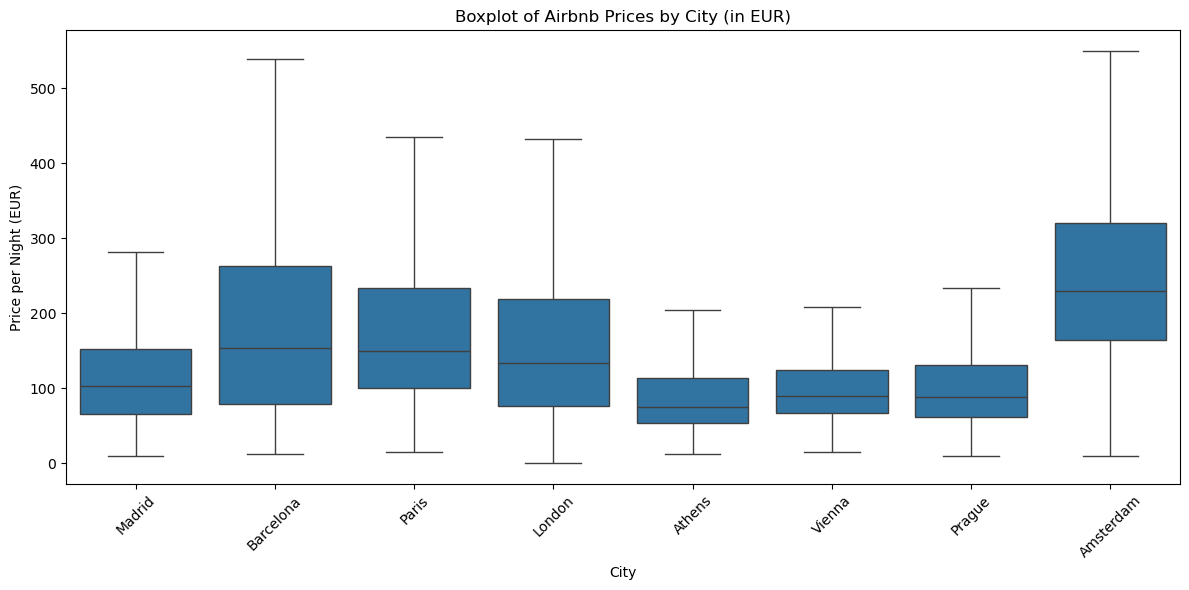

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=listings, x='city', y='price_clean', showfliers=False)  # showfliers=False hides extreme outliers for clarity

plt.title('Boxplot of Airbnb Prices by City (in EUR)')
plt.ylabel('Price per Night (EUR)')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Cleaning calendar dataset**

In [40]:
import pandas as pd

cities = ["Paris", "London", "Madrid", "Barcelona", "Vienna", "Athens", "Amsterdam", "Prague"]

for city in cities:
    path = f"Airbnb_June2024_June2025/{city}/calendar.csv"
    df = pd.read_csv(path)
    print(f"--- {city} ---")
    percent_null = (df.isnull().mean() * 100)
    percent_null = percent_null[percent_null > 0].round(2)
    print(percent_null)
    print()

C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\1202762288.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


--- Paris ---
adjusted_price    99.95
minimum_nights     0.00
maximum_nights     0.00
dtype: float64



C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\1202762288.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


--- London ---
adjusted_price    99.98
minimum_nights     0.00
maximum_nights     0.00
dtype: float64

--- Madrid ---
adjusted_price    100.0
dtype: float64



C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\1202762288.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


--- Barcelona ---
adjusted_price    99.99
minimum_nights     0.00
maximum_nights     0.00
dtype: float64

--- Vienna ---
adjusted_price    100.0
dtype: float64

--- Athens ---
adjusted_price    100.0
minimum_nights      0.0
maximum_nights      0.0
dtype: float64

--- Amsterdam ---
adjusted_price    100.0
minimum_nights      0.0
maximum_nights      0.0
dtype: float64

--- Prague ---
adjusted_price    100.0
dtype: float64



In [41]:
import pandas as pd

cities = ["Paris", "London", "Madrid", "Barcelona", "Vienna", "Athens", "Amsterdam", "Prague"]

czk_to_eur = 0.04  # Conversion rate 

for city in cities:
    path = f"Airbnb_June2024_June2025/{city}/calendar.csv"
    df = pd.read_csv(path)
    
    # Remove 'adjusted_price' column if it exists
    if 'adjusted_price' in df.columns:
        df.drop(columns=['adjusted_price'], inplace=True)
    
    # Rename 'price' to 'local_price'
    df.rename(columns={'price': 'local_price'}, inplace=True)
    
    # Clean local_price and convert to float
    df['price_clean'] = df['local_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    
    # Convert Prague prices from CZK to EUR
    if city.lower() == 'prague':
        df['price_clean'] = df['price_clean'] * czk_to_eur
        
    print(df['price_clean'].head(5))
    print()

C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\1225826563.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


0    250.0
1    250.0
2    250.0
3    250.0
4    250.0
Name: price_clean, dtype: float64



C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\1225826563.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


0    65.0
1    65.0
2    65.0
3    65.0
4    65.0
Name: price_clean, dtype: float64

0    30.0
1    30.0
2    30.0
3    30.0
4    30.0
Name: price_clean, dtype: float64



C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\1225826563.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


0    200.0
1    200.0
2    200.0
3    200.0
4    200.0
Name: price_clean, dtype: float64

0    65.0
1    65.0
2    65.0
3    65.0
4    65.0
Name: price_clean, dtype: float64

0    180.0
1    180.0
2    180.0
3    180.0
4    180.0
Name: price_clean, dtype: float64

0    200.0
1    200.0
2    200.0
3    200.0
4    200.0
Name: price_clean, dtype: float64

0    6.24
1    6.24
2    6.24
3    6.24
4    6.24
Name: price_clean, dtype: float64



In [ ]:
import pandas as pd

cities = ["Paris", "London", "Madrid", "Barcelona", "Vienna", "Athens", "Amsterdam", "Prague"]

czk_to_eur = 0.04  # Conversion rate 

for city in cities:
    path = f"Airbnb_June2024_June2025/{city}/calendar.csv"
    df = pd.read_csv(path)
    
    # Remove 'adjusted_price' column if it exists
    if 'adjusted_price' in df.columns:
        df.drop(columns=['adjusted_price'], inplace=True)
    
    # Rename 'price' to 'local_price'
    df.rename(columns={'price': 'local_price'}, inplace=True)
    
    # Clean local_price and convert to float
    df['price_clean'] = df['local_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    
    # Convert Prague prices from CZK to EUR
    if city.lower() == 'prague':
        df['price_clean'] = df['price_clean'] * czk_to_eur

    # Save cleaned DataFrame with '_cleaned' at the end of the filename
    save_path = f"Airbnb_June2024_June2025/{city}/calendar_cleaned.csv"
    df.to_csv(save_path, index=False)

Our analysis focuses on Airbnb listings across eight major European cities: Amsterdam, Athens, Barcelona, Madrid, Prague, Vienna, London, and Paris. We used a comprehensive dataset that includes key details about each listing, such as location, price, and review scores.

**Total Listings:** Over 100,000 listings across all cities.

**latitude and longitude:** Geographical coordinates for mapping.

**price:** The nightly cost of each listing.

**review_scores_rating:** Overall rating of each listing.

**review_scores_cleanliness, review_scores_communication, review_scores_location:** Category-specific review scores.

**city:** Identifies the city of each listing.

To ensure our analysis is accurate and consistent, we performed the following cleaning steps:

**Loading Data:**

We loaded the datasets for each city using pandas, creating separate DataFrames. These were combined into a single DataFrame for unified analysis.

We handled **missing values**. Listings with missing values in critical columns (latitude, longitude, price, review_scores_rating) were removed. Empty review scores were filled with the average score of the respective city to maintain data consistency.

Prices stored as text were converted to numeric values for accurate calculations. Outliers were identified using the interquartile range method and removed.

Duplicate listings were removed ensuring that each listing was unique in terms of its ID and location.

Review scores were converted to numeric values for analysis. We ensured all review scores were within the range of 1 to 5.

A **city** column was added to distinguish listings by city.

**BASIC STATISTICS**

1. London and Paris have the highest number of listings. Athens and Prague have the fewest.
2. Prices range from as €10 to over €1,000 per night with London and Paris having the highest average prices
3. Most cities maintain high review scores (above 4.0/5.0).
4. In each city, specific neighborhoods (like Kolonaki in Athens and the Gothic Quarter in Barcelona) have the highest Airbnb density.

2. DATA ANALYSIS

Our data analysis focused on uncovering key insights about Airbnb listings in eight major European cities: Amsterdam, Athens, Barcelona, Madrid, Prague, Vienna, London, and Paris. Our analysis aimed to answer three main questions. 

Pricing varies significantly by city, with Paris and London having the highest median prices. Occupancy rates are seasonal, with peaks during the summer months for most cities. The distribution of host types varies, with cities like Paris showing a high concentration of commercial hosts. Market concentration is high in some cities, with a small number of hosts controlling a large share of listings. The growth of Airbnb hosts has slowed in recent years, especially in major cities like Paris and London.

3. GENRE

Our project uses a **"Martini Glass"** narrative structure, a storytelling approach that begins with a clear introduction and context (the introduction sections), follows a structured, guided narrative (through the various visualizations we provide), and then opens up for user exploration (with interactive maps and review scores).

We chose the Martini Glass Structure for its clear introduction, starting with context and an overview of the cities, followed by a guided narrative that leads users through visualizations on listings, earnings, focused heatmaps, and best or worst Airbnbs. Finally, it offers interactive exploration, allowing users to dive deeper into the data with interactive maps and review scores.

Visual Narrative Structure: Our website follows a clear, structured path from context (listings, earnings) to more focused insights (heatmaps, best/worst Airbnbs) and finally to open exploration (interactive maps and scores). Also, we use clear color coding in our maps (red for worst, green for best) to draw attention to key insights. The website combines different types of visualizations (bar plots, heatmaps, and interactive maps) to provide a complete view. Users can explore different cities and review categories interactively.

We introduce the dataset and explain the purpose of the analysis. Then, each section is structured to guide users through the insights we have discovered and users can interact with the maps, filter review scores and explore the best/worst listings.


5. VISUALIZATIONS

*-Explain the visualizations you've chosen*

*-Why are they right for the story you want to tell?*

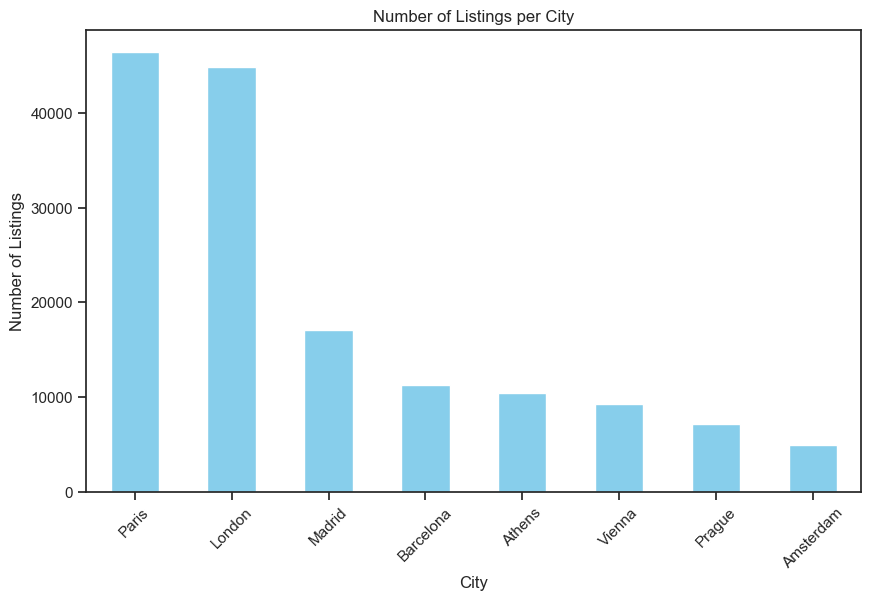

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("C:/Users/vasil/Desktop/Msc/4th term/Social Data Analysis and Visualization/Final Project/Airbnb_June2024_June2025/combined_listings.csv")

# Group by city and count listings
listings_per_city = df['city'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
listings_per_city.plot(kind='bar', color='skyblue')
plt.title('Number of Listings per City')
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show() 

This bar chart shows how many Airbnb listings each city has. It gives a quick view of which cities have the most or fewest Airbnbs.

Paris and London have the most listings, making them major Airbnb hotspots Madrid and Barcelona also have a lot, while Athens, Vienna, Prague, and Amsterdam have fewer.

It shows which cities rely most on Airbnb, setting the stage for understanding how it affects them.

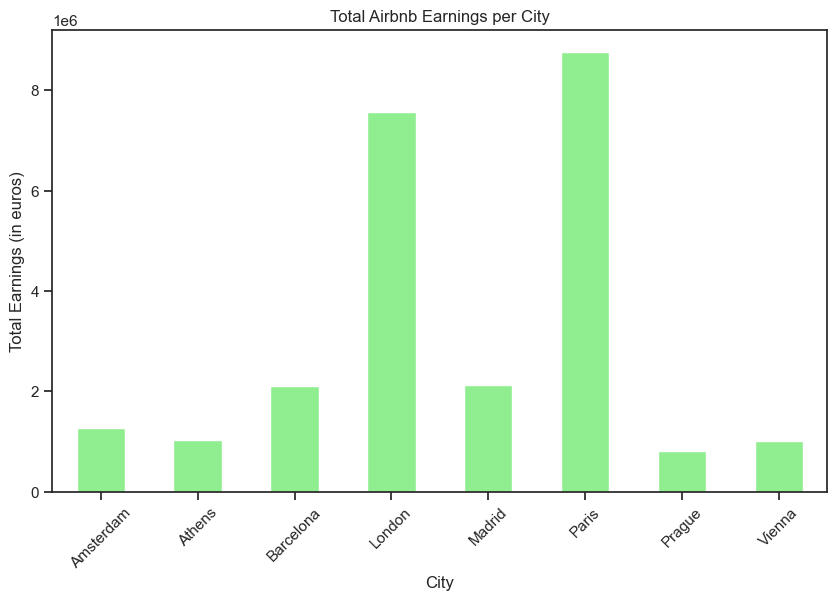

In [54]:
df['price_clean'] = pd.to_numeric(df['price_clean'].replace('[\$,]', '', regex=True))

# Group by city and calculate total earnings
earnings_per_city = df.groupby('city')['price_clean'].sum()

# Plotting the bar plot for earnings
plt.figure(figsize=(10, 6))
earnings_per_city.plot(kind='bar', color='lightgreen')
plt.title('Total Airbnb Earnings per City')
plt.xlabel('City')
plt.ylabel('Total Earnings (in euros)')
plt.xticks(rotation=45)
plt.show()

This bar chart shows how much money Airbnb hosts in each city made in total. It reveals which cities earn the most from short-term rentals.

Paris and London make the most money, far ahead of the others. Barcelona and Madrid also earn a lot, while Athens, Vienna, Prague, and Amsterdam earn less.

It highlights which cities see the biggest financial impact from Airbnb.

In [55]:
import folium
import geopandas as gpd
from folium.features import CustomIcon

# Create a map centered over Europe
europe_map = folium.Map(location=[54.5260, 15.2551], zoom_start=4)

# City data (coordinates, tourists, revenue)
city_data = {
    'Amsterdam': {'coords': [52.3676, 4.9041], 'tourists': 9000000, 'revenue': 7000000000, 'color': '#4B0082'},
    'Athens': {'coords': [37.9838, 23.7275], 'tourists': 4000000, 'revenue': 3000000000, 'color': '#228B22'},
    'Barcelona': {'coords': [41.3851, 2.1734], 'tourists': 10000000, 'revenue': 8000000000, 'color': '#FF8C00'},
    'Madrid': {'coords': [40.4168, -3.7038], 'tourists': 6000000, 'revenue': 5000000000, 'color': '#FF4500'},
    'Prague': {'coords': [50.0755, 14.4378], 'tourists': 8000000, 'revenue': 6000000000, 'color': '#1E90FF'},
    'Vienna': {'coords': [48.2082, 16.3738], 'tourists': 7000000, 'revenue': 5500000000, 'color': '#FF69B4'},
    'London': {'coords': [51.5074, -0.1278], 'tourists': 21700000, 'revenue': 31500000000, 'color': '#00008B'},
    'Paris': {'coords': [48.8566, 2.3522], 'tourists': 17400000, 'revenue': 25000000000, 'color': '#8B0000'}
}

# Load a simple GeoJSON file for Europe (you can replace this with a more detailed one)
europe_geojson = 'https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson'

# Add the colored regions for each city
for city, data in city_data.items():
    folium.Circle(
        location=data['coords'],
        radius=40000,  # Adjust this to cover the city area
        color=data['color'],
        fill=True,
        fill_color=data['color'],
        fill_opacity=0.3
    ).add_to(europe_map)

    # Add colored pin markers
    folium.Marker(
        location=data['coords'],
        icon=folium.Icon(color='white', icon='info-sign', icon_color=data['color']),
        tooltip=f"{city}<br>Tourists: {data['tourists']:,}<br>Revenue: €{data['revenue'] / 1e9:.1f}B"
    ).add_to(europe_map)

# Save the map to an HTML file
europe_map.save('europe_tourism_map_colored_pins.html')


This map shows where tourists go and how much money each city makes from Airbnb. The map helps connect tourist numbers with Airbnb revenue.

ondon and Paris are the biggest tourist magnets and also earn the most from Airbnb. Also, Barcelona, Madrid, and Prague have lots of tourists but earn less, showing different pricing or stay lengths. Lastly, Athens and Vienna have fewer tourists and lower Airbnb earnings.

It shows how tourism and Airbnb earnings are connected, highlighting which cities benefit most.

In [57]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load the dataset (Replace with your dataset path)
df = pd.read_csv("C:/Users/vasil/Desktop/Msc/4th term/Social Data Analysis and Visualization/Final Project/Airbnb_June2024_June2025/combined_listings.csv")

# Filter data for Amsterdam
amsterdam_data = df[df['city'] == 'Amsterdam'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Amsterdam
amsterdam_map = folium.Map(location=[52.3676, 4.9041], zoom_start=12)

# Add the HeatMap layer
HeatMap(amsterdam_data, radius=15, blur=10, max_zoom=1).add_to(amsterdam_map)

# Save the map
amsterdam_map.save('amsterdam_heatmap.html')

# Filter data for Athens
athens_data = df[df['city'] == 'Athens'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Athens
athens_map = folium.Map(location=[37.9838, 23.7275], zoom_start=12)

# Add the HeatMap layer
HeatMap(athens_data, radius=15, blur=10, max_zoom=1).add_to(athens_map)

# Save the map
athens_map.save('athens_heatmap.html')

# Filter data for Barcelona
barcelona_data = df[df['city'] == 'Barcelona'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Barcelona
barcelona_map = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# Add the HeatMap layer
HeatMap(barcelona_data, radius=15, blur=10, max_zoom=1).add_to(barcelona_map)

# Save the map
barcelona_map.save('barcelona_heatmap.html')

# Filter data for Madrid
madrid_data = df[df['city'] == 'Madrid'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Madrid
madrid_map = folium.Map(location=[40.4168, -3.7038], zoom_start=12)

# Add the HeatMap layer
HeatMap(madrid_data, radius=15, blur=10, max_zoom=1).add_to(madrid_map)

# Save the map
madrid_map.save('madrid_heatmap.html')

# Filter data for Prague
prague_data = df[df['city'] == 'Prague'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Prague
prague_map = folium.Map(location=[50.0755, 14.4378], zoom_start=12)

# Add the HeatMap layer
HeatMap(prague_data, radius=15, blur=10, max_zoom=1).add_to(prague_map)

# Save the map
prague_map.save('prague_heatmap.html')

# Filter data for Vienna
vienna_data = df[df['city'] == 'Vienna'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Vienna
vienna_map = folium.Map(location=[48.2082, 16.3738], zoom_start=12)

# Add the HeatMap layer
HeatMap(vienna_data, radius=15, blur=10, max_zoom=1).add_to(vienna_map)

# Save the map
vienna_map.save('vienna_heatmap.html')

# Filter data for London
london_data = df[df['city'] == 'London'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for London
london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Add the HeatMap layer
HeatMap(london_data, radius=15, blur=10, max_zoom=1).add_to(london_map)

# Save the map
london_map.save('london_heatmap.html')

# Filter data for Paris
paris_data = df[df['city'] == 'Paris'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a Folium map for Paris
paris_map = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Add the HeatMap layer
HeatMap(paris_data, radius=15, blur=10, max_zoom=1).add_to(paris_map)

# Save the map
paris_map.save('paris_heatmap.html')

Heatmaps show where Airbnb listings are most concentrated in each city, revealing tourist hotspots and quieter areas.

Paris, London, and Barcelona have the most crowded areas. Also, Athens and Vienna are more spread out. Popular areas in each city are easily visible.

We used Folium and HeatMap to create maps for each city. Each map is generated using a simple script that loads listing coordinates and creates a heatmap. We combined them into an interactive HTML file **(Full_heatmap_interactive.html)** where users can switch between cities.

This helps us understand where Airbnb is most active and how it affects neighborhoods.

In [58]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Filter data for Athens (Problem Areas)
athens_data = df[df['city'] == 'Athens'][['latitude', 'longitude']].dropna().values.tolist()

# Initialize a detailed map of Athens focusing on problem areas
athens_focus_map = folium.Map(location=[37.9838, 23.7275], zoom_start=14)

# Add the HeatMap layer
HeatMap(athens_data, radius=15, blur=10, max_zoom=1).add_to(athens_focus_map)

# Highlight Problem Areas (Kolonaki, Koukaki, Pangrati, Exarchia)
neighborhoods = {
    'Kolonaki': [37.9773, 23.7437],
    'Koukaki': [37.9640, 23.7247],
    'Pangrati': [37.9713, 23.7446],
    'Exarchia': [37.9891, 23.7314]
}

for name, coords in neighborhoods.items():
    folium.Circle(
        location=coords,
        radius=300,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.2
    ).add_to(athens_focus_map)

    folium.Marker(
        location=coords,
        popup=f'{name} - Area with rising rents and Airbnb impact',
        icon=folium.Icon(color='red')
    ).add_to(athens_focus_map)

# Save the enhanced focused map
athens_focus_map.save('enhanced_focused_athens_heatmap_extended.html')

This heatmap focuses specifically on central areas of Athens, highlighting neighborhoods like Kolonaki, Koukaki, Pangrati, and Exarchia, which are known for their dense concentration of Airbnb listings. This allows for a more detailed understanding of Airbnb's impact in these areas. 

Kolonaki and Koukaki are major hotspots, with many Airbnb listings, indicating their popularity among tourists. Also, Pangrati also shows significant activity, reflecting its growing reputation as a trendy neighborhood. Exarchia, known for its alternative culture, has a moderate number of listings, but they are concentrated in specific pockets.

Focusing on these neighborhoods helps us understand how Airbnb affects specific parts of Athens, providing a clear view of the areas most impacted. This is essential for our analysis of Airbnb's influence on local communities.

In [59]:
# Filter data for Barcelona
barcelona_data = df[df['city'] == 'Barcelona'][['latitude', 'longitude']].dropna().values.tolist()

# Coordinates of key neighborhoods affected by rental bans
neighborhoods = {
    'Eixample': [41.3888, 2.1590],
    'Gothic Quarter': [41.3809, 2.1738]
}

# Initialize a Folium map for Barcelona
barcelona_map = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# Add the HeatMap layer
HeatMap(barcelona_data, radius=15, blur=10, max_zoom=1).add_to(barcelona_map)

# Add neighborhood markers with delineations
for name, coords in neighborhoods.items():
    folium.Marker(
        location=coords,
        popup=f'Neighborhood: {name} - Affected by Rental Ban',
        icon=folium.Icon(color='darkblue', icon='warning-sign')
    ).add_to(barcelona_map)

    # Add circles around the areas to highlight impact
    folium.Circle(
        location=coords,
        radius=500,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2
    ).add_to(barcelona_map)

# Save the map
barcelona_map.save('enhanced_barcelona_heatmap.html')

This heatmap focuses on the areas of Barcelona most impacted by Airbnb, including the Gothic Quarter and Eixample. It highlights the dense concentration of listings in these popular neighborhoods.

Gothic Quarter is major hotspots, known for their tourist appeal. Eixample, another central district, also shows a high density of Airbnb listings.

By focusing on these neighborhoods, we get a clear view of how Airbnb affects housing in Barcelona, making it easier to understand local issues like rising rents and displacement.

In [60]:
from bokeh.plotting import figure, output_file, show, save
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Legend
import pandas as pd

# Assuming df is already loaded with the necessary columns
# Filtering necessary columns
df_filtered = df[['city', 
                  'review_scores_rating',
                  'review_scores_cleanliness',
                  'review_scores_communication',
                  'review_scores_location']].dropna()

# Calculating average scores for each city
average_scores = df_filtered.groupby('city').mean().reset_index()

# Setting up Bokeh data source
source = ColumnDataSource(average_scores)

# Creating the Bokeh figure
p = figure(title='Average Review Scores by City', x_range=average_scores['city'], width=1000, height=700)

# Creating bars with pastel colors and increased width
r_clean = p.vbar(x='city', top='review_scores_cleanliness', source=source, width=0.25, color='#AEC6CF', muted_alpha=0.1)
r_comm = p.vbar(x='city', top='review_scores_communication', source=source, width=0.25, color='#FFB6C1', muted_alpha=0.1)
r_loc = p.vbar(x='city', top='review_scores_location', source=source, width=0.25, color='#FFDAB9', muted_alpha=0.1)
r_rate = p.vbar(x='city', top='review_scores_rating', source=source, width=0.25, color='#C5E3BF', muted_alpha=0.1)

# Adding Hover Tool
hover = HoverTool(tooltips=[
    ('City', '@city'),
    ('Cleanliness', '@review_scores_cleanliness'),
    ('Communication', '@review_scores_communication'),
    ('Location', '@review_scores_location'),
    ('Overall Rating', '@review_scores_rating')
])
p.add_tools(hover)

# Custom Legend outside the plot
legend = Legend(items=[
    ('Cleanliness', [r_clean]),
    ('Communication', [r_comm]),
    ('Location', [r_loc]),
    ('Overall Rating', [r_rate])
], location='center', orientation='horizontal')

p.add_layout(legend, 'below')
p.legend.click_policy = 'mute'

p.xaxis.axis_label = 'City'
p.yaxis.axis_label = 'Average Review Score'

# Saving the interactive plot
output_file('interactive_average_scores_by_city_pastel_legend_below.html')
save(p)

'c:\\Users\\vasil\\Desktop\\Msc\\4th term\\Social Data Analysis and Visualization\\Final Project\\interactive_average_scores_by_city_pastel_legend_below.html'

This interactive bar plot shows the average review scores across four categories (Cleanliness, Communication, Location, and Overall Rating) for each city. It allows users to quickly compare the quality of Airbnb experiences in different locations.

Most cities maintain consistently high scores, typically above 8/10. Additionally, some cities excel in specific categories, like Paris in Location and Athens in Communication, while others show slightly lower scores in categories like Cleanliness. Users can click on the legend to show or hide categories, making it easy to focus on specific aspects.

We used Bokeh for an interactive bar plot. The scores for each city were calculated based on the average of all listings, categorized by **Cleanliness**, **Communication**, **Location**, and **Overall Rating**. The interactive legend allows users to click and toggle each category, making it easy to explore the data.

This plot provides a clear and user-friendly way to compare traveler satisfaction across cities. It highlights which cities consistently deliver high-quality experiences and which may struggle in certain areas.

In [61]:
import pandas as pd
import folium

# Filtering necessary columns
df_filtered = df[['city', 'latitude', 'longitude',
                  'review_scores_rating', 'neighbourhood_cleansed']].dropna()

# Function to create map of 2 best and 2 worst airbnbs
def create_best_worst_map(city_name, n=2):
    # Filtering for the specific city
    city_df = df_filtered[df_filtered['city'] == city_name]

    # Selecting the best and worst Airbnbs
    best_airbnbs = city_df.nlargest(n, 'review_scores_rating')
    worst_airbnbs = city_df.nsmallest(n, 'review_scores_rating')

    # Create a base map
    city_map = folium.Map(location=[city_df['latitude'].mean(), city_df['longitude'].mean()], zoom_start=13)

    # Adding Best Airbnbs
    for _, row in best_airbnbs.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Best Airbnb: {row['review_scores_rating']}\nNeighborhood: {row['neighbourhood_cleansed']}",
            icon=folium.Icon(color='green', icon='star')
        ).add_to(city_map)

    # Adding Worst Airbnbs
    for _, row in worst_airbnbs.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Worst Airbnb: {row['review_scores_rating']}\nNeighborhood: {row['neighbourhood_cleansed']}",
            icon=folium.Icon(color='red', icon='remove')
        ).add_to(city_map)

    # Save the map
    map_filename = f"{city_name}_best_worst_airbnbs.html"
    city_map.save(map_filename)
    print(f"Map saved as {map_filename}")

# Example for Madrid, Vienna, and Prague
create_best_worst_map('Madrid')
create_best_worst_map('Vienna')
create_best_worst_map('Prague')
create_best_worst_map('Amsterdam')
create_best_worst_map('London')


Map saved as Madrid_best_worst_airbnbs.html
Map saved as Vienna_best_worst_airbnbs.html
Map saved as Prague_best_worst_airbnbs.html
Map saved as Amsterdam_best_worst_airbnbs.html
Map saved as London_best_worst_airbnbs.html


This interactive setup allows users to explore the best and worst-rated Airbnbs in six major European cities: Madrid, Vienna, Prague, London, and Amsterdam. By clicking on each city, users can see maps highlighting the two highest-rated (green) and two lowest-rated (red) listings in each city.

Often located in central or trendy neighborhoods, offering good amenities and quality service. Typically appear in less central areas or areas with known issues, such as cleanliness or safety. Specific neighborhoods with consistently low ratings may indicate local problems affecting guest satisfaction.

We used Folium and Leaflet to create interactive maps for each city. Each city has two markers for the best listings (5-star rating) and two for the worst (1-star rating). The setup is organized in an HTML file **(reviews.html)**.

This visualization helps identify which neighborhoods consistently offer the best or worst Airbnb experiences. It also allows for a quick comparison of user satisfaction across different cities.

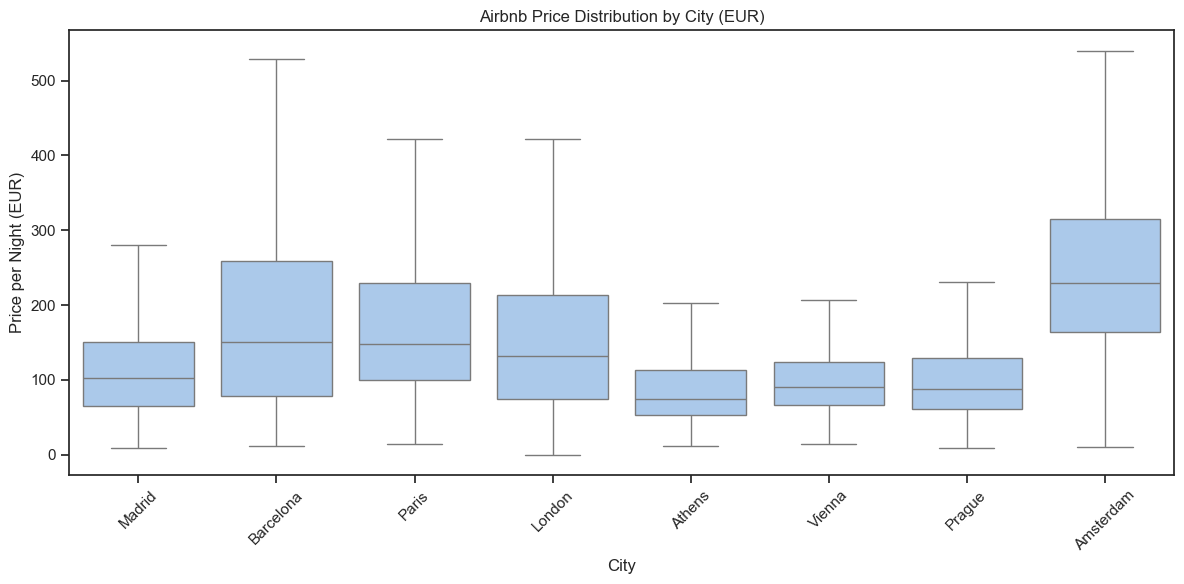

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="pastel")


# Price distribution
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='city', y='price_clean', showfliers=False)
plt.title('Airbnb Price Distribution by City (EUR)')
plt.ylabel('Price per Night (EUR)')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Save the figure in high quality (e.g., 300 DPI)

This box plot provides a clear and concise representation of the distribution of Airbnb prices across eight European cities. It highlights the median, quartiles, and outliers for each city, making it easy to compare price variations.

Cities like Amsterdam, Paris, and London exhibit higher median prices, indicating they are generally more expensive for Airbnb stays. Athens, Prague, and Vienna have lower price distributions, making them relatively more affordable for visitors. The plot also reveals significant price variability in some cities (like Amsterdam and London), suggesting the presence of both budget and luxury options.

By showing price distributions, this plot provides context on the cost of Airbnb accommodations across cities. It allows readers to see which cities are more expensive and which offer more affordable stays, which is a critical factor in understanding the economic impact of Airbnb on both tourists and locals.

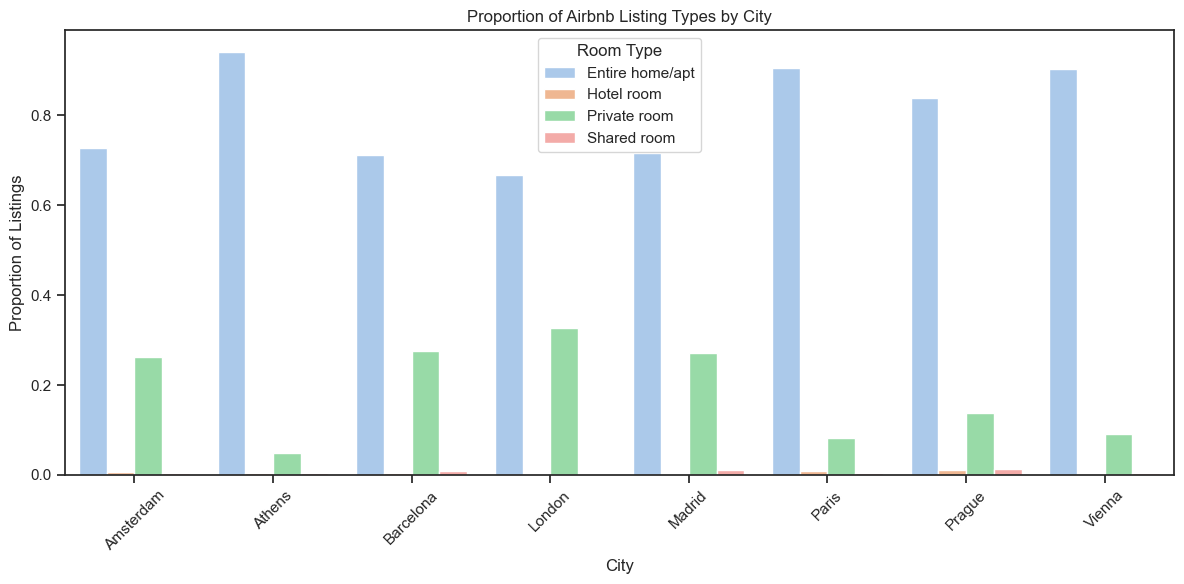

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate proportions
prop_df = (
    df.groupby(['city', 'room_type'])
    .size()
    .reset_index(name='count')
)

# Calculate total listings per city
city_totals = prop_df.groupby('city')['count'].transform('sum')
prop_df['proportion'] = prop_df['count'] / city_totals

sns.set(style="ticks", palette="pastel")
# Plot proportions
plt.figure(figsize=(12,6))
sns.barplot(
    data=prop_df,
    x='city',
    y='proportion',
    hue='room_type'
)
plt.title('Proportion of Airbnb Listing Types by City')
plt.xlabel('City')
plt.ylabel('Proportion of Listings')
plt.xticks(rotation=45)
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

This bar plot provides a clear, comparative view of the different types of Airbnb listings available in each city. By categorizing listings into Entire home/apt, Hotel room, Private room, and Shared room, it allows for an immediate understanding of the dominant accommodation type in each city. 

Most cities, like Paris, London, Vienna, and Prague, are dominated by Entire home/apt listings, indicating that many hosts operate full apartments or houses rather than single rooms. Also, Athens and Madrid have a higher proportion of Private rooms, which suggests a larger market for shared accommodations. The presence of Hotel rooms is minimal, except for Barcelona, where it is slightly more noticeable, which aligns with the city's dual identity as a hotel and Airbnb hub.

This plot directly supports our narrative by showing the nature of accommodations available in each city

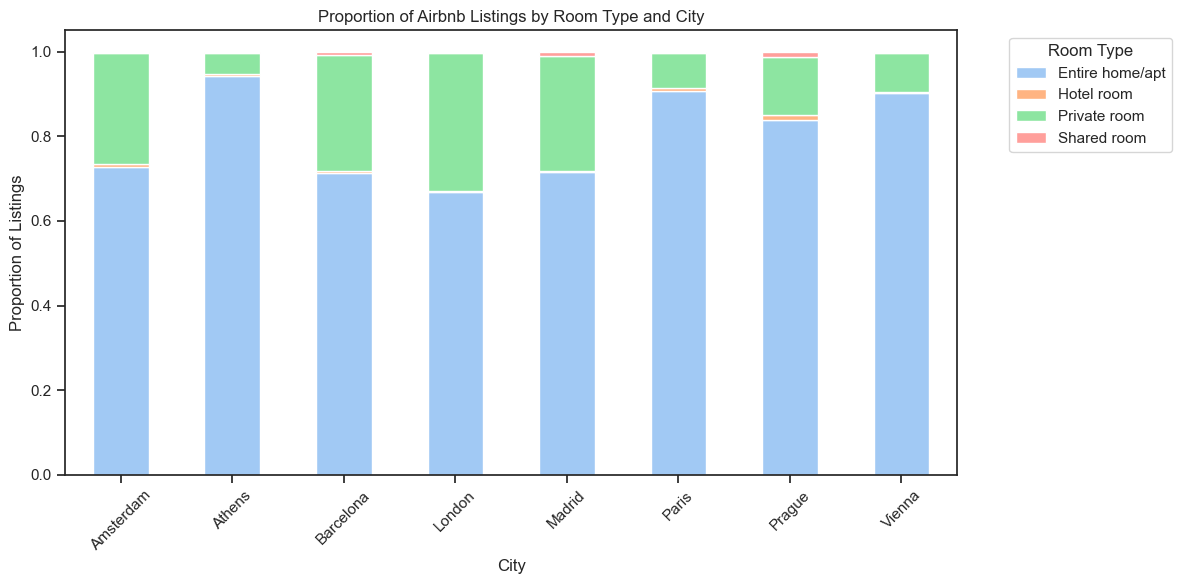

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a crosstab of room_type counts per city
room_type_counts = pd.crosstab(df['city'], df['room_type'])

# Convert counts to proportions per city (row-wise)
room_type_props = room_type_counts.div(room_type_counts.sum(axis=1), axis=0)

room_type_props.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6))

plt.title('Proportion of Airbnb Listings by Room Type and City')
plt.xlabel('City')
plt.ylabel('Proportion of Listings')
plt.xticks(rotation=45)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This stacked bar plot provides a detailed view of the distribution of Airbnb listing types in each city. Unlike a standard bar plot, the stacked format allows for a direct comparison of proportions within each city while maintaining the total count of listings.

Entire home/apt is the dominant listing type across all cities, especially in Paris, London, Vienna, and Prague, indicating a strong preference for renting out full properties. Cities like Athens, Amsterdam, and Madrid have a higher proportion of Private rooms, reflecting a trend where hosts offer part of their homes instead of the entire property. Hotel rooms are almost non-existent in most cities except for Barcelona, where they represent a small but noticeable portion. This aligns with the city’s large tourism industry and dual identity as a hotel and Airbnb hub. Shared rooms, the least popular option, have minimal representation in all cities, suggesting that travelers prefer privacy over shared spaces.

This visualization helps us explore how Airbnb is utilized in each city — whether it serves as a traditional hotel alternative or a more social, shared experience.

In [68]:
def classify_guest_type(row):
    if row['accommodates'] == 1:
        return 'Solo Traveler (1)'
    elif row['accommodates'] == 2:
        return 'Couple (2)'
    elif row['accommodates'] >= 6:
        return 'Large Group (> 6)'
    elif row['accommodates'] >= 3:
        return 'Family/Small Group (3-5)'
    else:
        return 'Other'

df['guest_type'] = df.apply(classify_guest_type, axis=1)

In [70]:
# Create a crosstab of guest_type counts per city
guest_type_counts = pd.crosstab(df['city'], df['guest_type'])

# Convert counts to proportions per city (row-wise)
guest_type_props = guest_type_counts.div(guest_type_counts.sum(axis=1), axis=0)

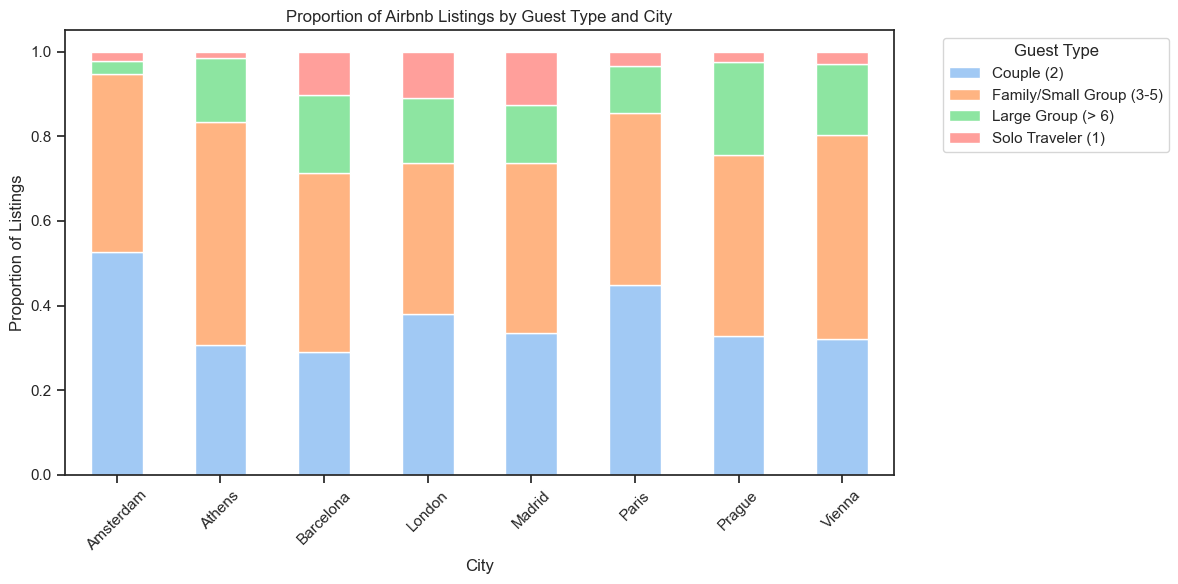

In [71]:
guest_type_props.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)

plt.title('Proportion of Airbnb Listings by Guest Type and City')
plt.xlabel('City')
plt.ylabel('Proportion of Listings')
plt.xticks(rotation=45)
plt.legend(title='Guest Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This Bar plot provides an overview of the types of travelers Airbnb listings in each city cater to. Cities like Amsterdam and Prague have a high proportion of listings suitable for Couples and small groups budget-friendly accommodations.

London, Paris, and Barcelona stand out for having a significant share of listings suitable for Large Groups, reflecting their popularity as destinations for group trips or family vacations. Solo Travelers make up a very small portion of listings in all cities, suggesting that most Airbnb hosts cater to multiple guests rather than individuals. This plot highlights the diversity in Airbnb offerings, showing how cities adapt to different traveler profiles.

Understanding the distribution of guest types across cities is essential for analyzing Airbnb’s impact. 

In [79]:
import pandas as pd

cities = ["Paris", "London", "Madrid", "Barcelona", "Vienna", "Athens", "Amsterdam", "Prague"]


# Example: loading and combining calendar files
dfs = []
for city in cities:
    df = pd.read_csv(f'Airbnb_June2024_June2025/{city}/calendar_cleaned.csv')
    df['city'] = city  # add city column
    dfs.append(df)
calendar_all = pd.concat(dfs, ignore_index=True)

In [80]:
# Convert 'available' to boolean: True if available, False if booked
calendar_all['is_available'] = calendar_all['available'] == 't'

# Group by city and date to calculate occupancy rate
occupancy = (
    calendar_all.groupby(['city', 'date'])
    .agg(
        total_listings=('listing_id', 'count'),
        available_listings=('is_available', 'sum')
    )
    .reset_index()
)
occupancy['occupancy_rate'] = 1 - (occupancy['available_listings'] / occupancy['total_listings'])

**Day of the week and months heatmap**

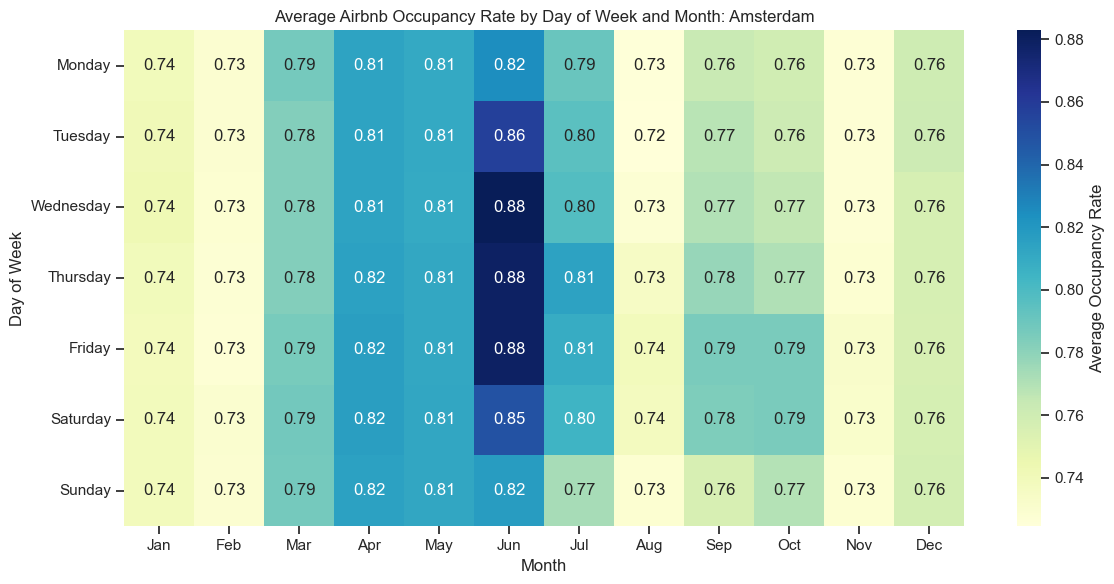

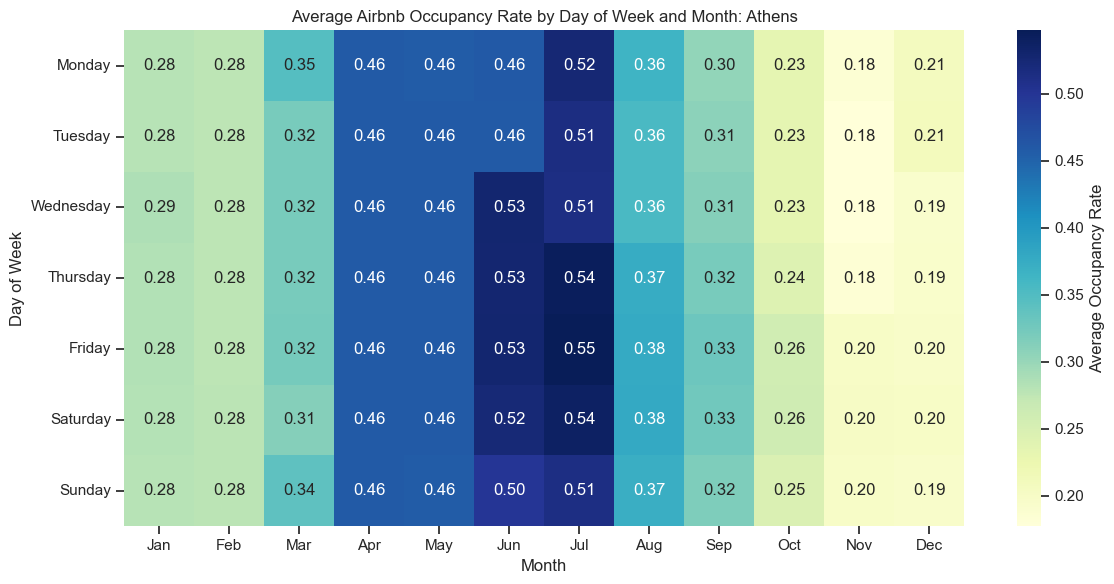

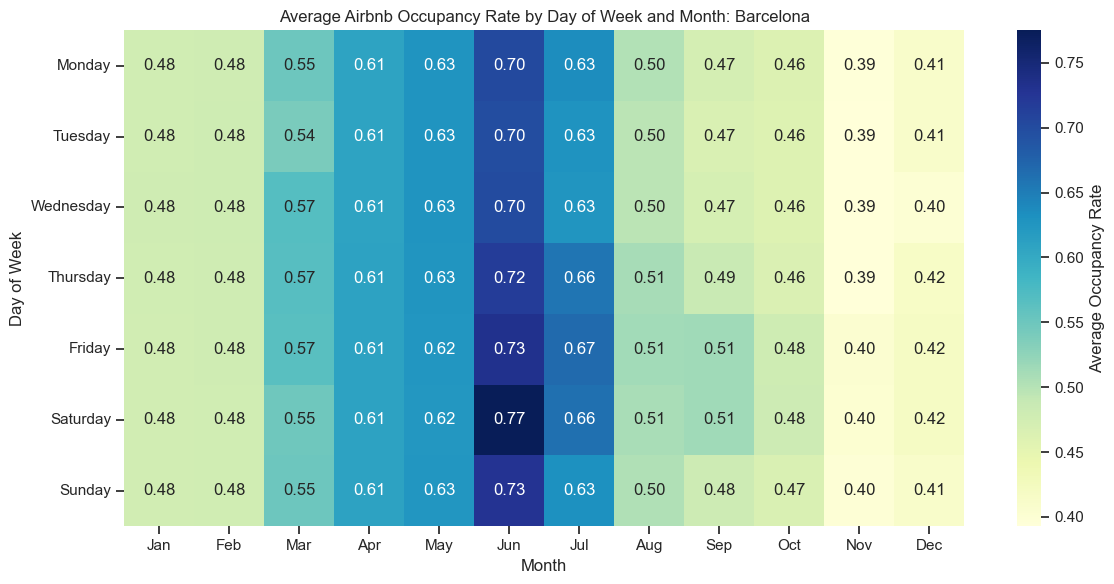

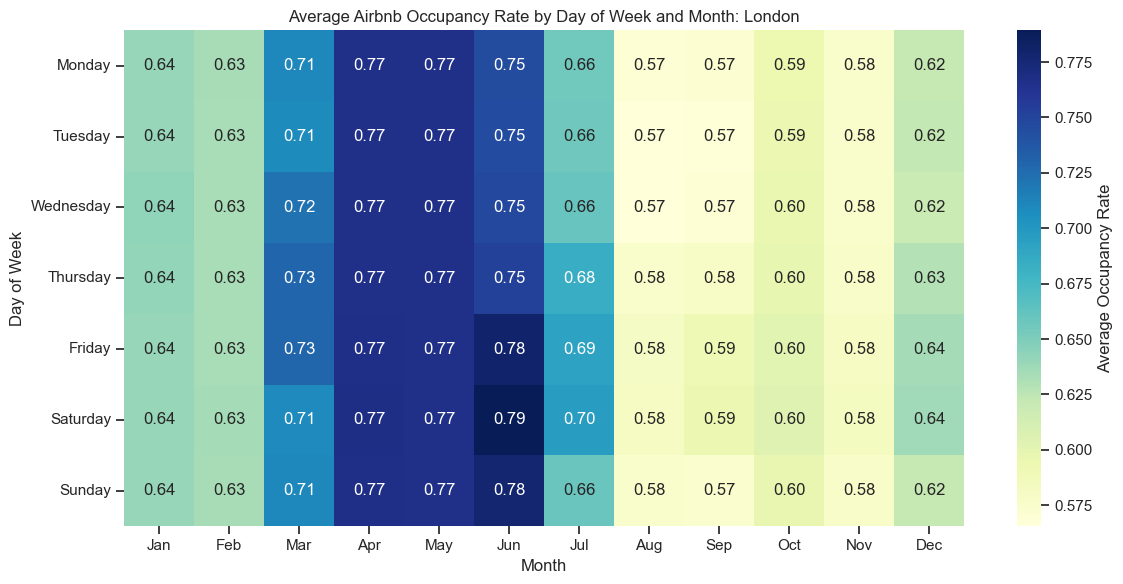

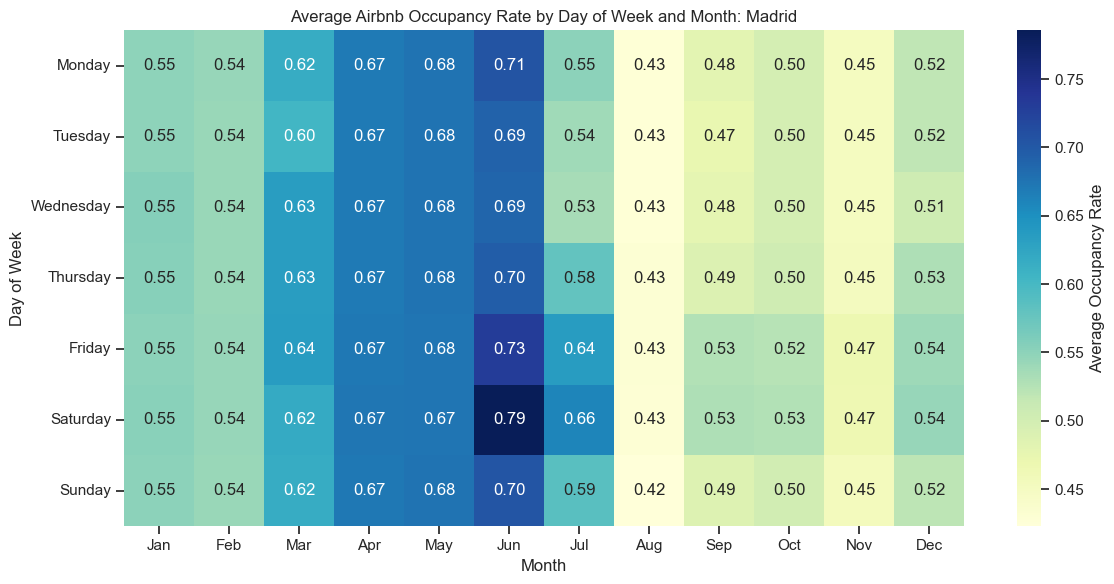

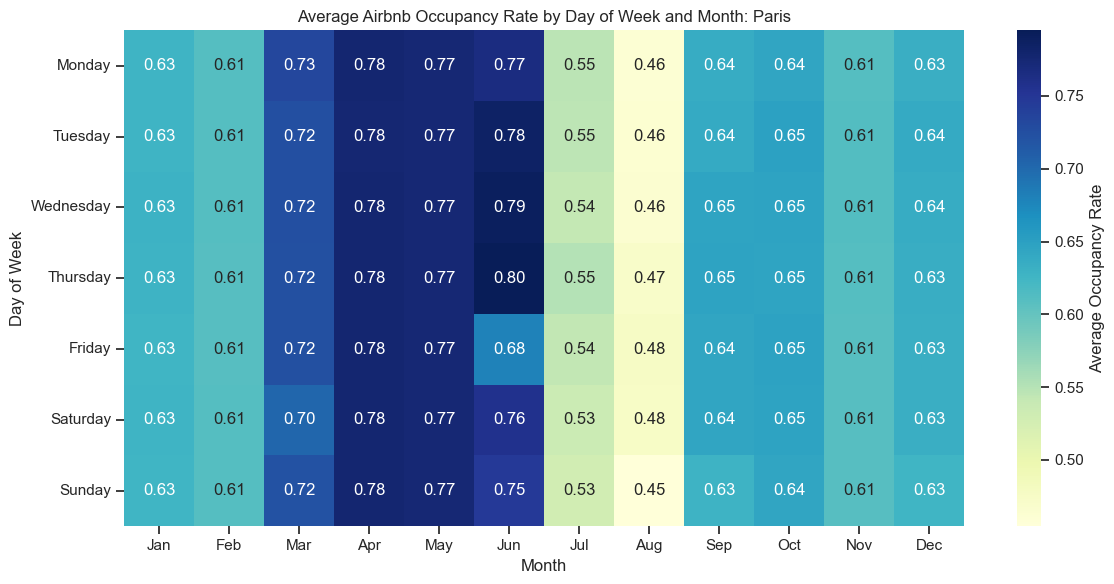

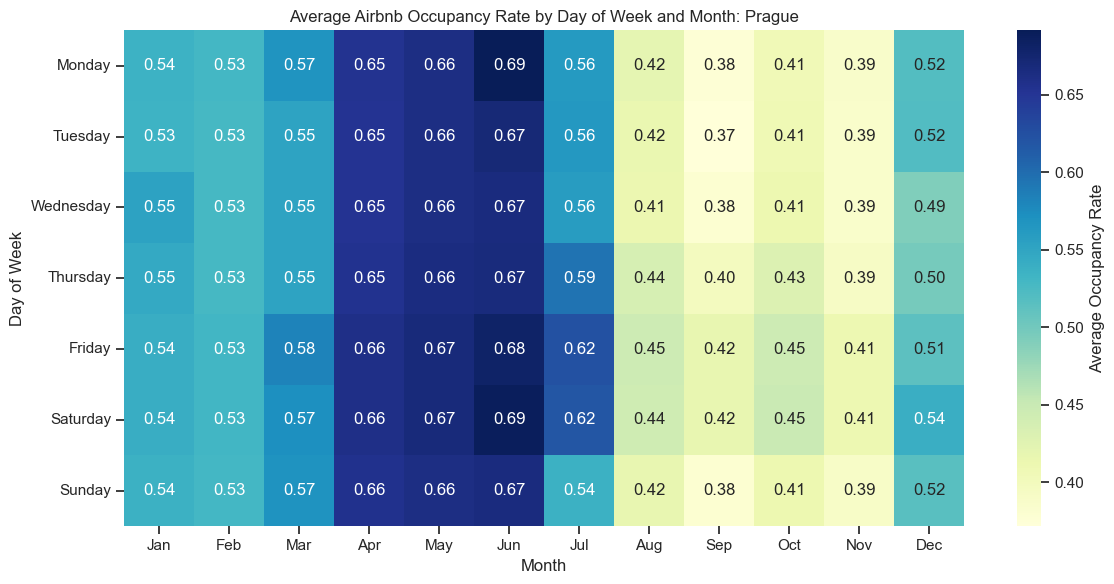

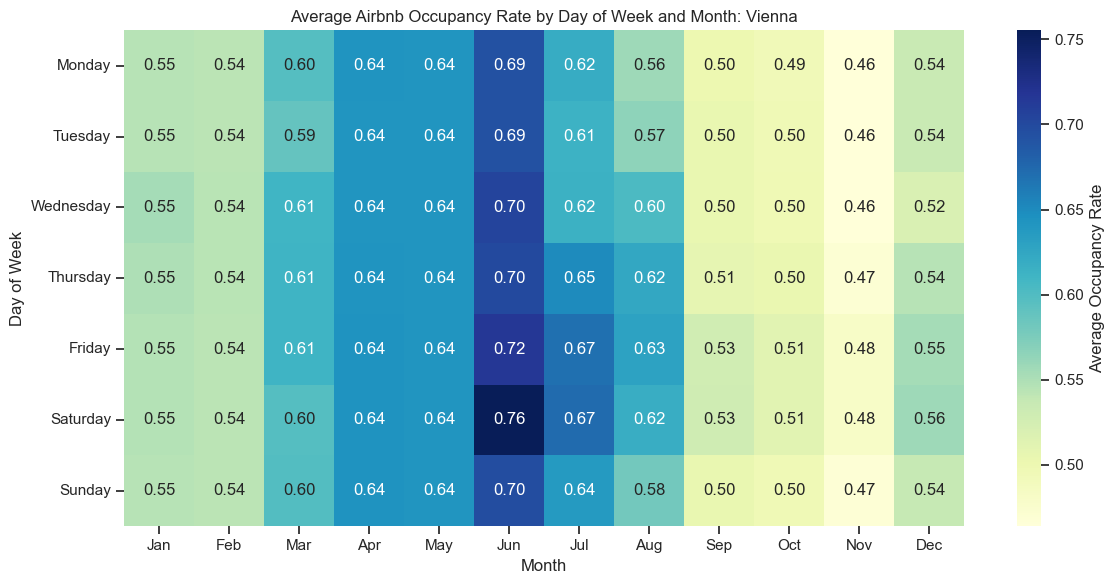

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure dates and categories
occupancy['date'] = pd.to_datetime(occupancy['date'])
occupancy['month'] = occupancy['date'].dt.strftime('%b')
occupancy['weekday'] = occupancy['date'].dt.day_name()

WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for city in occupancy['city'].unique():
    city_data = occupancy[occupancy['city'] == city]
    pivot = city_data.pivot_table(
        index='weekday',
        columns='month',
        values='occupancy_rate',
        aggfunc='mean'
    ).reindex(index=WEEKDAYS, columns=MONTHS)

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Occupancy Rate'})
    plt.title(f'Average Airbnb Occupancy Rate by Day of Week and Month: {city}')
    plt.xlabel('Month')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.show()

These heatmaps show the average Airbnb occupancy rate for each city across different days of the week and months. The color intensity highlights the busiest periods for each city, making it easy to identify high-demand seasons or popular travel days. The Bokeh interactive version allows users to click and explore the heatmaps for each city, offering a more engaging and flexible experience.

In [92]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category10
from bokeh.io import output_notebook

output_notebook()  # Use this if running in Jupyter Notebook

# Example data setup (replace 'filtered' with your actual DataFrame)
# filtered = your filtered DataFrame with 'city' and 'price_clean' columns

cities = df['city'].unique()
colors = Category10[len(cities)]  # Pastel palette for each city

p = figure(
    width=800, height=400,
    title="Overlayed Airbnb Price Histograms by City",
    x_axis_label='Price (EUR)',
    y_axis_label='Count'
)

# Remove grid lines
p.xgrid.visible = False
p.ygrid.visible = False

# Add hover tool
hover = HoverTool(
    tooltips=[
        ("City", "@city"),
        ("Bin", "@left{0.0} – @right{0.0}"),
        ("Count", "@top")
    ]
)
p.add_tools(hover)

for i, city in enumerate(cities):
    city_prices = combined[combined['city'] == city]['price_clean']
    hist, edges = np.histogram(city_prices, bins=30)
    
    # Create a ColumnDataSource for hover
    source = ColumnDataSource(data=dict(
        top=hist,
        left=edges[:-1],
        right=edges[1:],
        city=[city]*len(hist)
    ))
    
    p.quad(
        top='top', bottom=0,
        left='left', right='right',
        fill_color=colors[i], line_color="white", fill_alpha=0.5,
        legend_label=str(city),
        source=source
    )

p.legend.click_policy = "hide"
p.legend.location = "top_right"

show(p)

Loading BokehJS ...

KeyError: 1

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for Amsterdam: 369


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


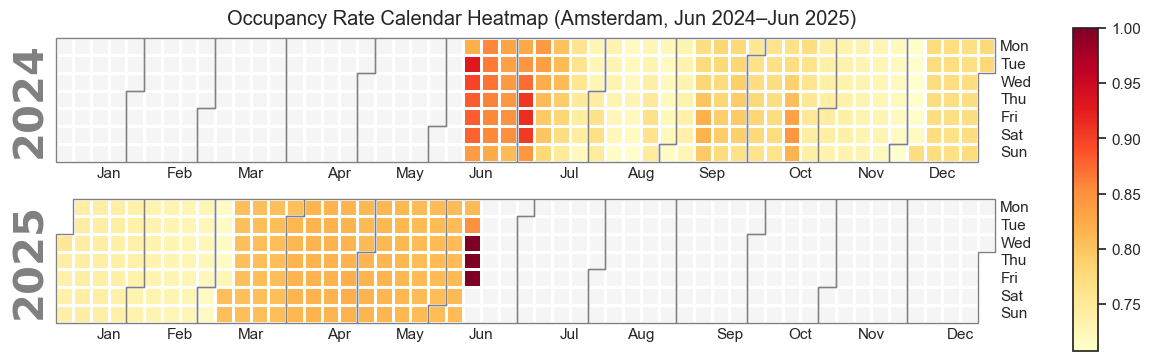

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for Athens: 366


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


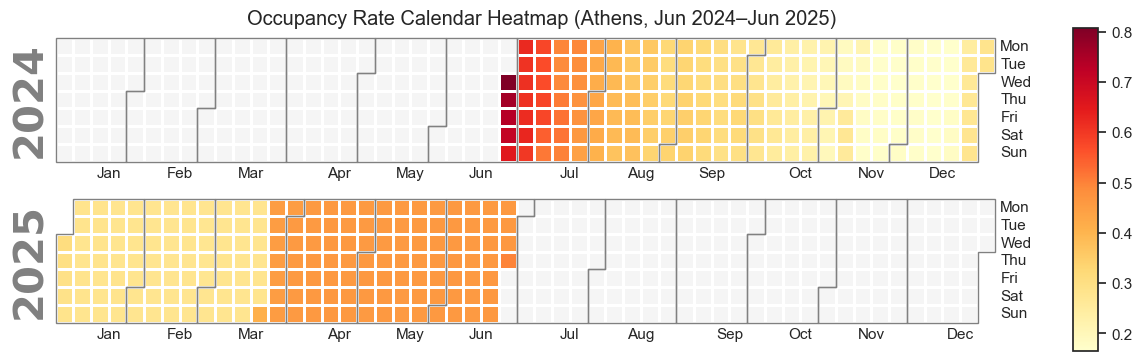

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for Barcelona: 365


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


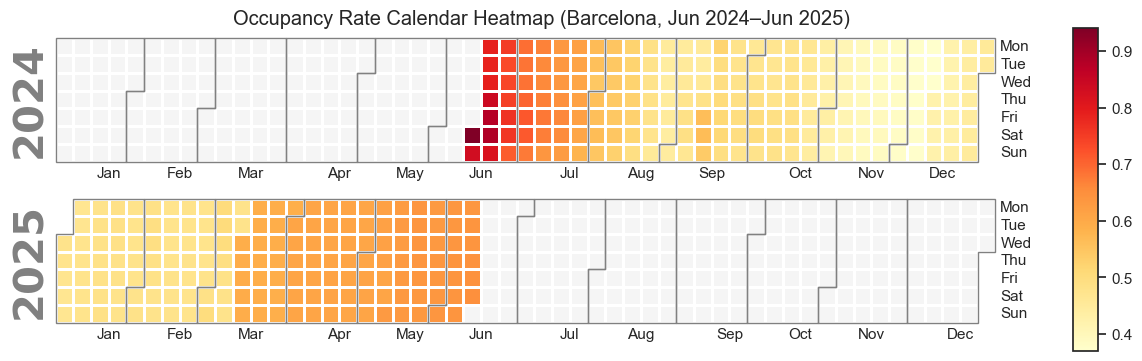

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for London: 371


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


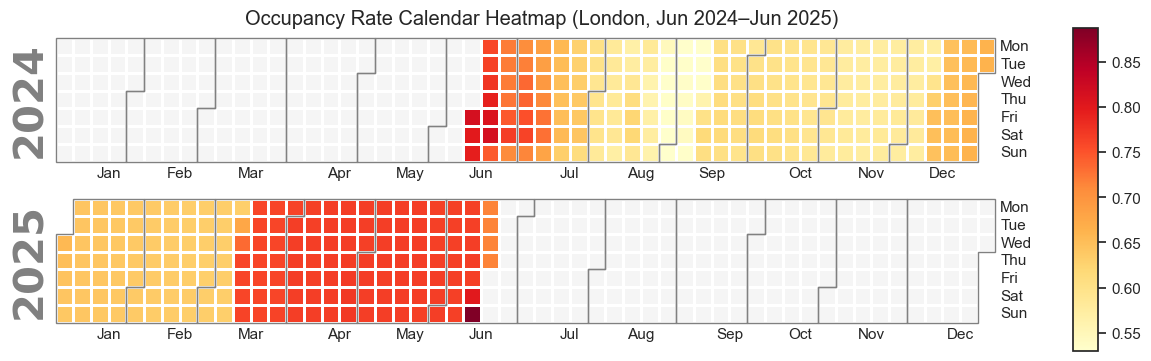

findfont: Font family 'Helvetica' not found.


Length of series for Madrid: 365


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


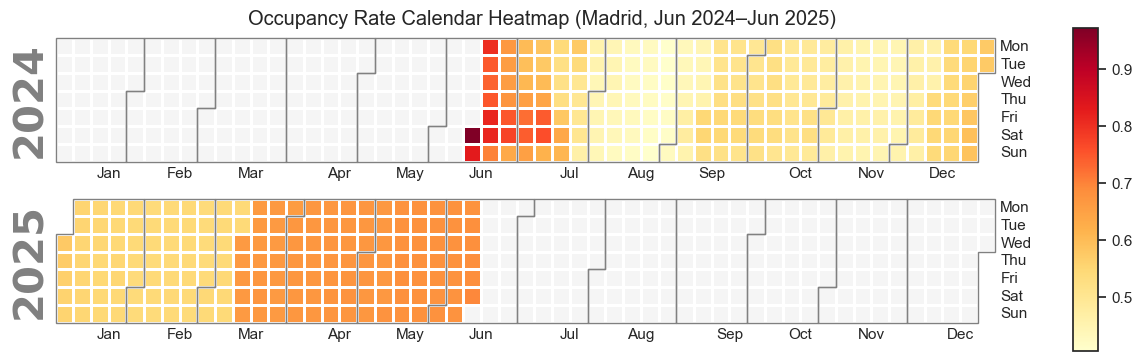

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for Paris: 368


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


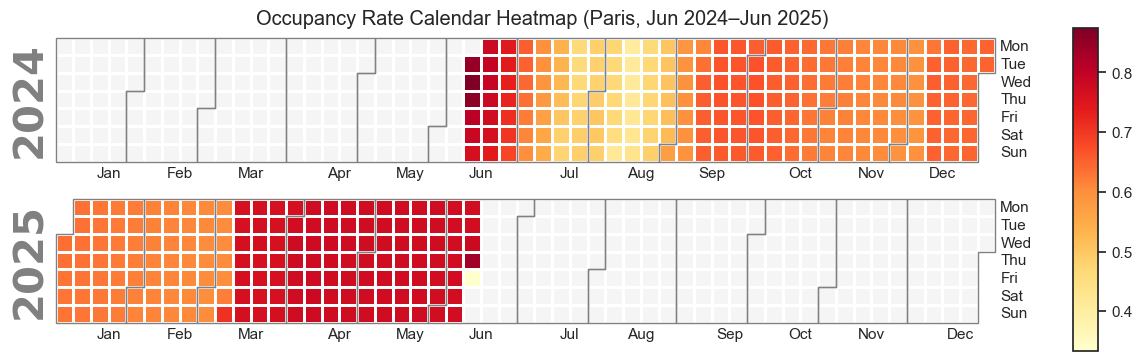

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for Prague: 365


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


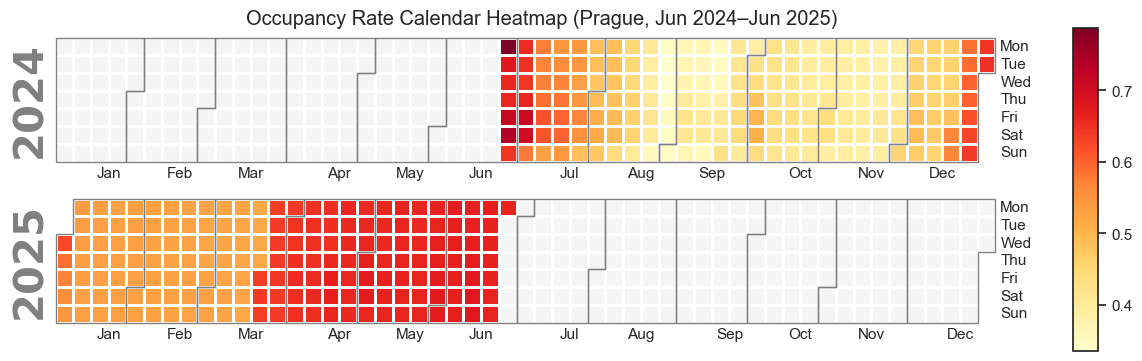

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Length of series for Vienna: 365


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


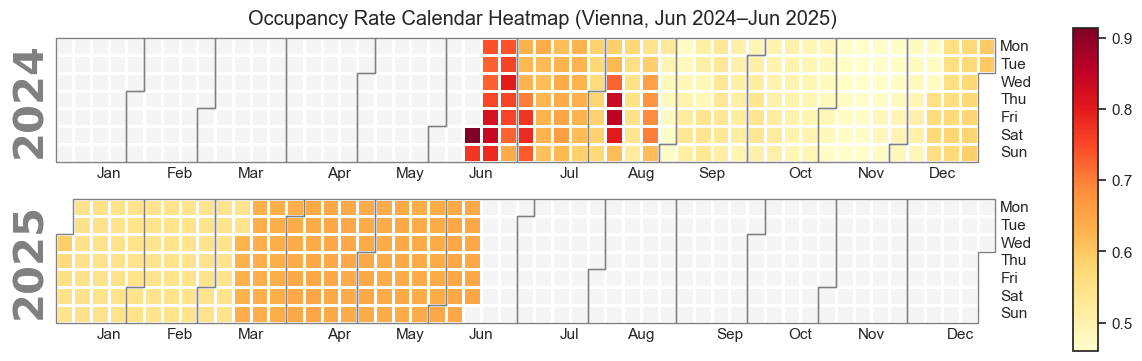

In [94]:
import calplot
import matplotlib.pyplot as plt
import pandas as pd

for city in occupancy['city'].unique():
    city_occ = occupancy[occupancy['city'] == city].copy()
    city_occ['date'] = pd.to_datetime(city_occ['date'])
    series = city_occ.set_index('date')['occupancy_rate'].dropna()
    
    print(f"Length of series for {city}: {len(series)}")  # Should be > 0

    if not series.empty:
        calplot.calplot(
            series,
            cmap='YlOrRd',
            colorbar=True,
            suptitle=f'Occupancy Rate Calendar Heatmap ({city.title()}, Jun 2024–Jun 2025)'
        )
        plt.show()
    else:
        print(f"No data for {city}.")


These occupancy rate calendar heatmaps provide a clear visualization of Airbnb occupancy patterns across the year for each city. The heatmaps are divided by months and days of the week, with color intensity indicating occupancy levels. This allows for an easy understanding of peak and low seasons. For instance, high occupancy in June can be clearly seen in cities like Amsterdam and London, aligning with their high tourism periods. Meanwhile, Athens shows increased occupancy in the summer months, matching the typical tourist season for a Mediterranean destination. These visuals allow for quick identification of trends and patterns, making it easier to understand the seasonality and peak periods for each city. The Bokeh interactive version allows users to click and explore the heatmaps for each city, offering a more engaging and flexible experience.

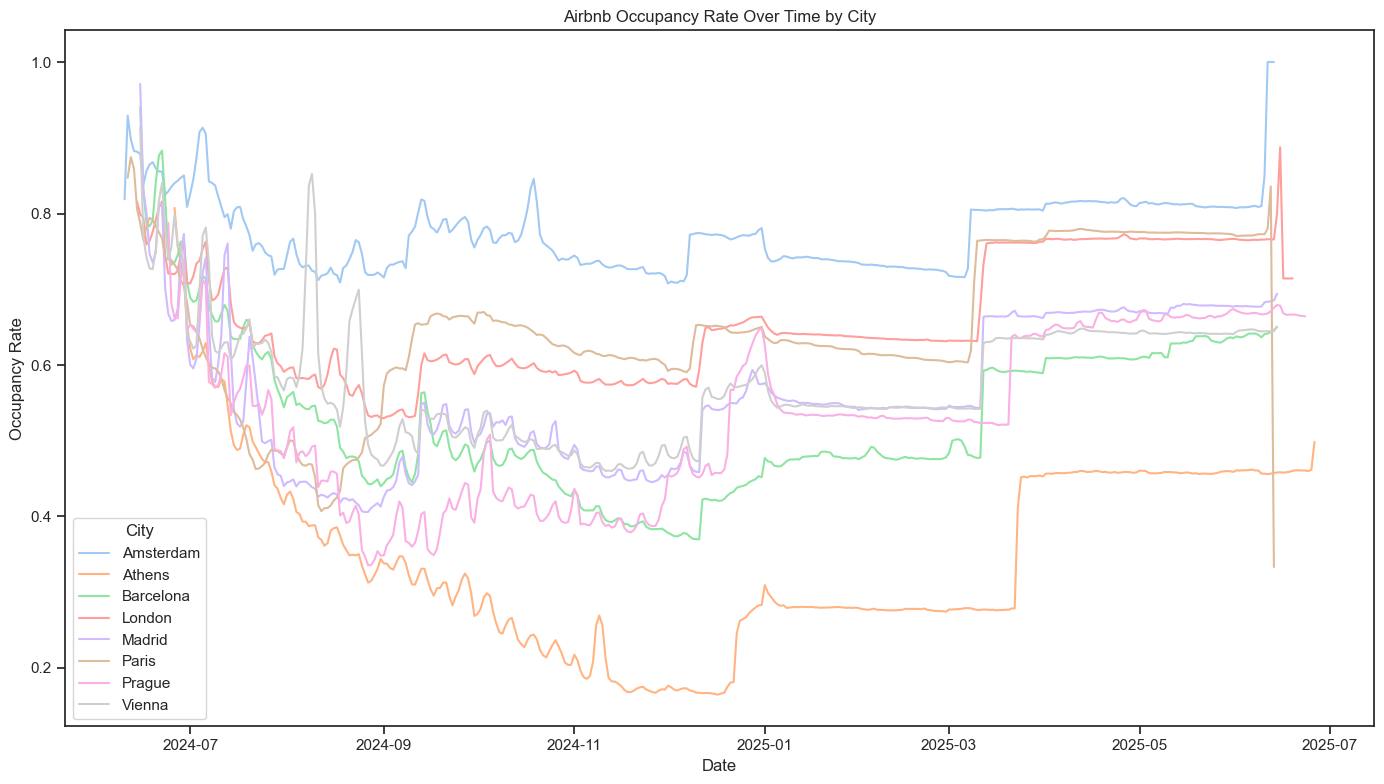

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(14, 8))
for city in occupancy['city'].unique():
    city_data = occupancy[occupancy['city'] == city]
    # Ensure 'date' is datetime and both are 1D arrays
    dates = pd.to_datetime(city_data['date']).to_numpy()
    rates = city_data['occupancy_rate'].to_numpy()
    plt.plot(dates, rates, label=city)

plt.title('Airbnb Occupancy Rate Over Time by City')
plt.xlabel('Date')
plt.ylabel('Occupancy Rate')
plt.legend(title='City')
plt.tight_layout()
plt.show()

In [97]:
import pandas as pd
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Category20
from bokeh.models import DatetimeTickFormatter


output_file("bokeh_plot_occupancy_by_city.html")

occupancy['date'] = pd.to_datetime(occupancy['date'])
occupancy = occupancy.sort_values('date')

cities = occupancy['city'].unique().tolist()
palette = Category20[20][:len(cities)]

p = figure(
    height=400,
    width=900,
    title="Airbnb Occupancy Rate Over Time by City",
    x_axis_label="Date",
    y_axis_label="Occupancy Rate",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    toolbar_location="right",
    x_axis_type="datetime",
)

p.title.text_font_size = "14pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"

xmin = occupancy['date'].min()
xmax = occupancy['date'].max()
p.x_range.start = xmin
p.x_range.end = xmax

for i, city in enumerate(cities):
    city_data = occupancy[occupancy['city'] == city].copy()
    source = ColumnDataSource(data={
        'date': city_data['date'],
        'rate': city_data['occupancy_rate'],
        'city': [city] * len(city_data)
    })
    line = p.line(
        x='date',
        y='rate',
        line_width=2,
        color=palette[i],
        legend_label=city,
        source=source,
        muted_alpha=0.0,
        muted=True,
        name=city
    )
   # Create circle glyph for data points (hover tool interacts only with circles)
    circle = p.circle(
        x='date',
        y='rate',
        size=5,
        color=palette[i],
        source=source,
        muted_alpha=0.0,  # Set muted alpha to hide points when muted
        muted=True,
    )
    
    # Add hover tool specifically for this district (circle glyph only)
    hover = HoverTool(
        renderers=[circle],  # Restrict hover tool to interact only with circles
        tooltips=[
            ("City", "@city"),
            ("Date", "@date{%F}"),
            ("Occupancy Rate", "@rate{0.0%}"),  # Show proportion (3 decimal places)
        ],
        formatters={"@date": "datetime"},
        mode="mouse",  # Use mouse mode for precise hover behavior
    )
    p.add_tools(hover)
    


p.legend.click_policy = "mute"
p.legend.location = "center_right"
p.legend.background_fill_alpha = 0.7
p.legend.label_text_font_size = "10pt"
p.legend.title = "City"
p.xaxis.formatter = DatetimeTickFormatter(
    months="%m/%Y",  # e.g., Jan 2023
    years="%m/%Y",   # keep the same format for years
)

p.xaxis[0].ticker.desired_num_ticks = 16  # or higher!

p.add_layout(p.legend[0], 'right')
output_file("bokeh_occupancy_time.html")
show(p)


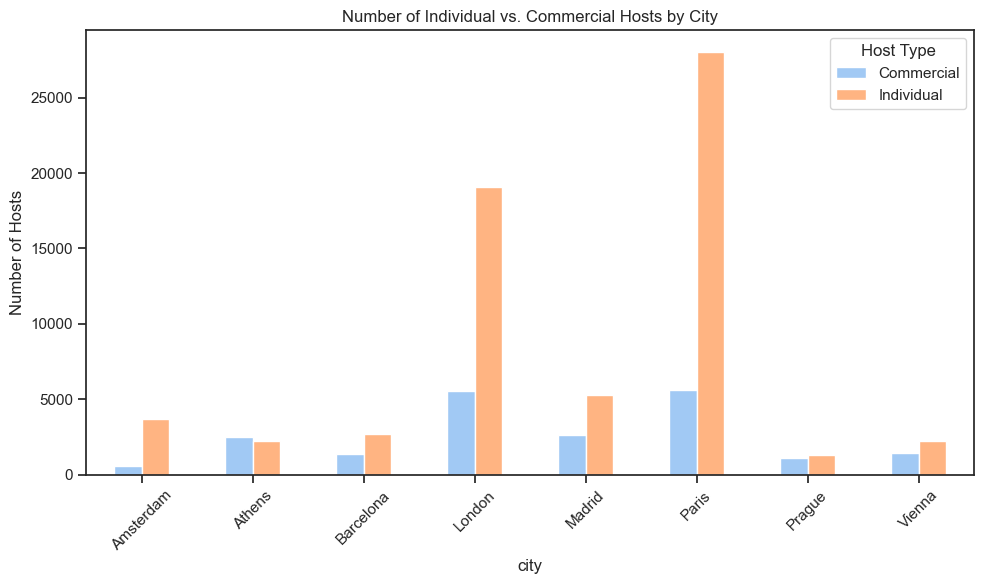

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style="ticks", palette="pastel")

host_types = (
    df.groupby(['city', 'host_id'])['instant_bookable']
    .apply(lambda x: (x == 't').any())
    .reset_index(name='is_commercial')
)

host_types['host_type'] = host_types['is_commercial'].apply(
    lambda x: 'Commercial' if x else 'Individual'
)


# Count number of hosts by city and type
city_type_counts = host_types.groupby(['city', 'host_type'])['host_id'].nunique().unstack(fill_value=0)

# Barplot
city_type_counts.plot(kind='bar', stacked=False, figsize=(10,6))
plt.ylabel('Number of Hosts')
plt.title('Number of Individual vs. Commercial Hosts by City')
plt.xticks(rotation=45)
plt.legend(title='Host Type')
plt.tight_layout()
plt.show()


This bar chart illustrates the distribution of Airbnb hosts across eight major European cities, divided into two categories: Individual Hosts (who manage a few listings) and Commercial Hosts (who manage multiple listings). 

Paris and London have a significantly higher number of individual hosts, indicating a more diverse host base with smaller-scale operators. Athens and Vienna show a relatively balanced mix between individual and commercial hosts. Cities like Amsterdam and Prague have a smaller number of both host types, suggesting a more niche market.

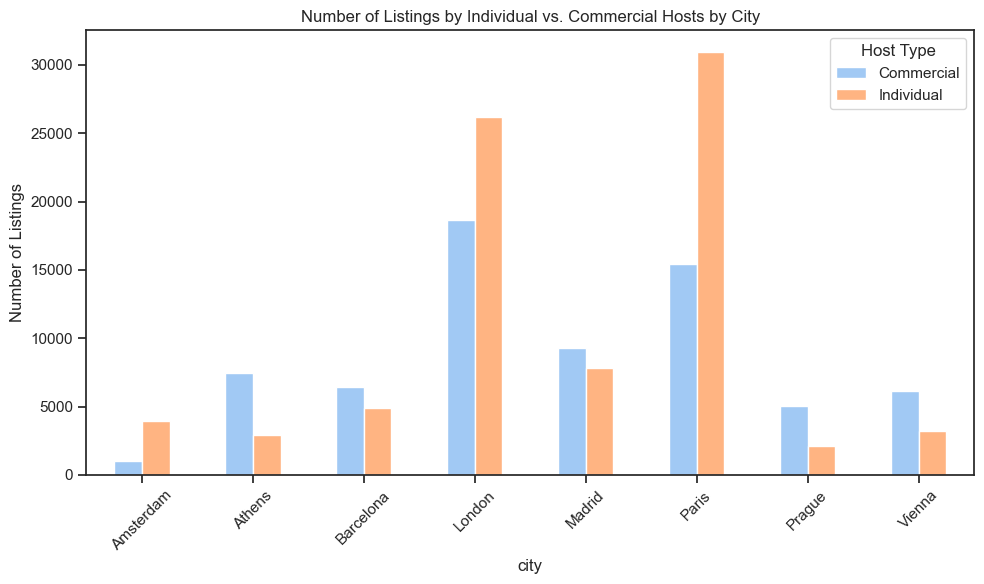

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Classify each host as Commercial or Individual based on instant_bookable
host_types = (
    df.groupby(['city', 'host_id'])['instant_bookable']
    .apply(lambda x: (x == 't').any())  # True if any listing is instant bookable
    .reset_index(name='is_commercial')
)
host_types['host_type'] = host_types['is_commercial'].apply(
    lambda x: 'Commercial' if x else 'Individual'
)

# 2. Merge host_type back into the combined DataFrame
combined_with_type = df.merge(
    host_types[['city', 'host_id', 'host_type']],
    on=['city', 'host_id'],
    how='left'
)

# 3. Group by city and host_type, count listings
city_type_listings = (
    combined_with_type.groupby(['city', 'host_type'])
    .size()
    .unstack(fill_value=0)
)

# 4. Plot
city_type_listings.plot(kind='bar', stacked=False, figsize=(10,6))
plt.ylabel('Number of Listings')
plt.title('Number of Listings by Individual vs. Commercial Hosts by City')
plt.xticks(rotation=45)
plt.legend(title='Host Type')
plt.tight_layout()
#plt.savefig('./plots_meus/hosts/numlist_by_host_type.png', dpi=300, bbox_inches='tight')  # PNG format
plt.show()


This bar chart shows the number of listings managed by Individual and Commercial in various European cities.

Paris and London stand out with a significantly higher number of listings managed by individual hosts, reflecting their vast and diverse Airbnb markets. Athens and Vienna demonstrate a balanced distribution between commercial and individual listings, indicating a mix of small-scale and larger-scale operators. In Amsterdam and Prague, commercial hosts have a notable presence,


In [122]:
import pandas as pd
import numpy as np

result = []

for city, group in df.groupby('city'):
    # Count how many listings each host has in this city
    host_listing_counts = group['host_id'].value_counts()
    total_listings = host_listing_counts.sum()
    # Sort hosts from biggest to smallest
    sorted_counts = host_listing_counts.sort_values(ascending=False)
    # Cumulative share of listings
    cumulative_share = np.cumsum(sorted_counts) / total_listings
    # Find how many hosts needed to reach 80% of listings
    num_hosts_80 = np.searchsorted(cumulative_share, 0.8) + 1  # +1 because 0-based index
    percent_hosts_80 = 100 * num_hosts_80 / len(sorted_counts)
    result.append({'city': city, 'percent_hosts_owning_80pct': percent_hosts_80})

df_80 = pd.DataFrame(result).sort_values('city')


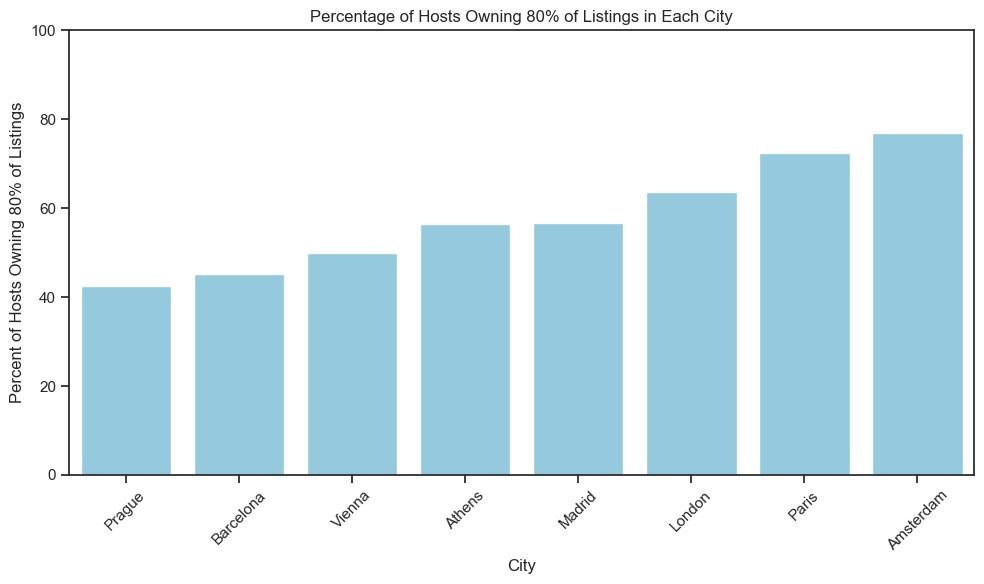

In [126]:
# Sort cities by percent_hosts_owning_80pct ascending (low to high)
df_80_sorted = df_80.sort_values('percent_hosts_owning_80pct', ascending=True)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_80_sorted,
    x='city',
    y='percent_hosts_owning_80pct',
    color='skyblue'
)
plt.ylabel('Percent of Hosts Owning 80% of Listings')
plt.xlabel('City')
plt.title('Percentage of Hosts Owning 80% of Listings in Each City')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

This bar chart visualizes the distribution of listings among hosts in various cities. 

Paris and Amsterdam have the highest concentration of listings managed by a small percentage of hosts, indicating a more commercialized market where a few hosts dominate. Prague and Barcelona show a more distributed ownership pattern, suggesting a more balanced market with less dominance by a few hosts.

This visualization emphasizes the "80/20 Rule", where a small proportion of hosts control a large share of the market.

C:\Users\vasil\AppData\Local\Temp\ipykernel_7608\819843568.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['city', 'bin'])


<Figure size 1200x700 with 0 Axes>

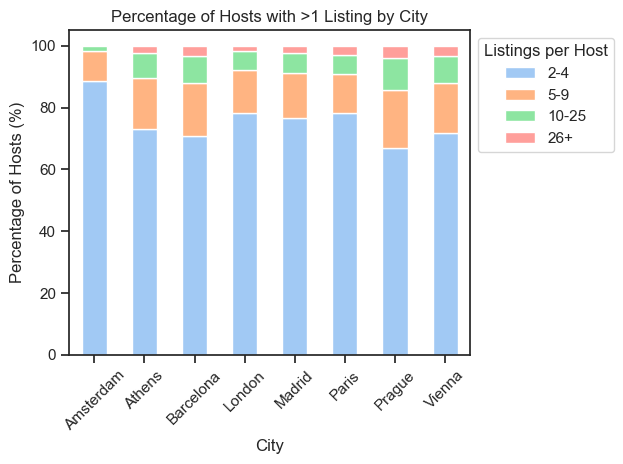

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Compute listings per host per city
host_counts_per_city = (
    df
    .groupby(['city', 'host_id'])
    .size()
    .reset_index(name='listing_count')
)

# STEP 2: Only hosts with more than 1 listing
host_counts_per_city = host_counts_per_city[host_counts_per_city['listing_count'] > 1]

# STEP 3: Bin the listing counts (using the new bins)
bins = [1, 4, 9, 25, float('inf')]    # 2-4, 5-9, 10-25, 26+
labels = ['2-4', '5-9', '10-25', '26+']
host_counts_per_city['bin'] = pd.cut(
    host_counts_per_city['listing_count'],
    bins=bins,
    labels=labels,
    right=True
)

# STEP 4: Group by city and bin, get counts
city_bin_counts = (
    host_counts_per_city
    .groupby(['city', 'bin'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=labels)
)

# STEP 5: Convert counts to percent (per city)
city_bin_perc = city_bin_counts.div(city_bin_counts.sum(axis=1), axis=0) * 100

# STEP 6: Plot
plt.figure(figsize=(12,7))
city_bin_perc.plot(
    kind='bar',
    stacked=True
)
plt.xlabel('City')
plt.ylabel('Percentage of Hosts (%)')
plt.title('Percentage of Hosts with >1 Listing by City')
plt.legend(title='Listings per Host', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This stacked bar chart shows the distribution of hosts who manage multiple listings across different cities.

The majority of hosts in all cities manage between 2-4 listings, reflecting a mix of individual and small-scale commercial operators. The proportion of hosts with 5-9 listings is consistent across cities, indicating a moderate commercial presence. Hosts managing 10-25 listings or 26+ listings are less common but are a key indicator of highly commercialized markets. Cities like Paris and Amsterdam have a noticeable share of hosts with 26+ listings, suggesting a stronger commercial influence.

This visualization highlights the diversity of host profiles and helps identify cities where Airbnb is more business-oriented.

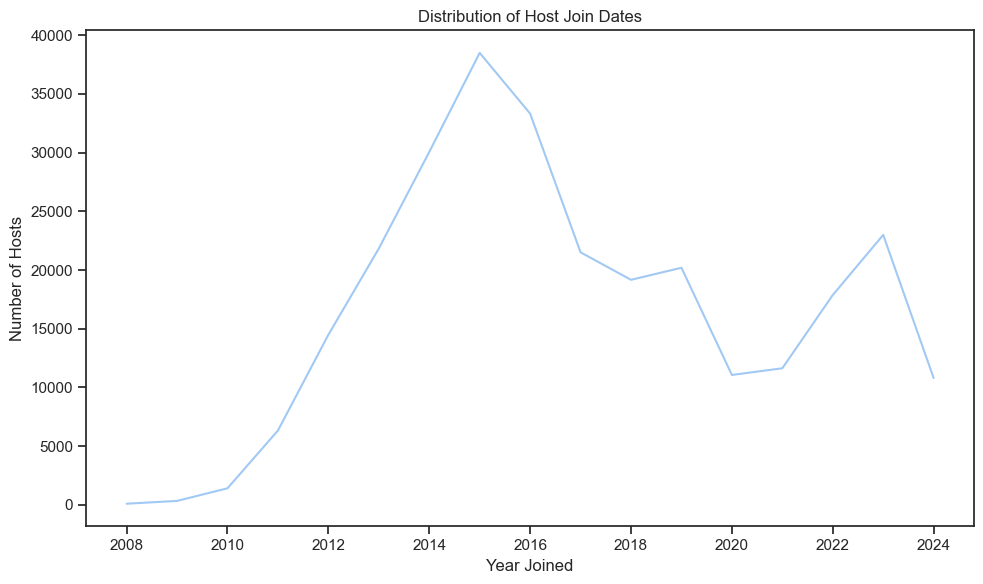

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to datetime if not already
df['host_since'] = pd.to_datetime(combined['host_since'])

# Count hosts by year
hosts_per_year = df['host_since'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(hosts_per_year.index.to_numpy(), hosts_per_year.values, linestyle='-')  # No marker argument
plt.xlabel('Year Joined')
plt.ylabel('Number of Hosts')
plt.title('Distribution of Host Join Dates')
plt.tight_layout()
plt.show()


In [125]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from bokeh.palettes import Category10

# If running in a Jupyter notebook, enable Bokeh output
output_notebook()

# --- Data Preparation ---

# Ensure 'host_since' is datetime
df['host_since'] = pd.to_datetime(combined['host_since'])

# Extract year
df['host_year'] = df['host_since'].dt.year

# Group by city and year, count unique hosts
hosts_per_year_city = (
    df.groupby(['city', 'host_year'])['host_id']
    .nunique()
    .reset_index()
    .sort_values(['city', 'host_year'])
)

# Pivot so each city is a column, index is year
pivot = hosts_per_year_city.pivot(index='host_year', columns='city', values='host_id').fillna(0)
years = pivot.index.tolist()
cities = pivot.columns.tolist()
data = [pivot[city].values for city in cities]

# --- Bokeh Plotting ---

p = figure(
    title="Number of New Airbnb Hosts Per Year by City",
    x_axis_label='Year Joined',
    y_axis_label='Number of Hosts',
    width=900,
    height=500,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

# Use a color palette with enough colors
palette = Category10[10] if len(cities) <= 10 else Category10[10] * ((len(cities) // 10) + 1)

for i, city in enumerate(cities):
    color = palette[i % len(palette)]
    r = p.line(
        years, data[i],
        line_width=2,
        color=color,
        legend_label=city,
        name=city
    )
    p.circle(years, data[i], size=6, color=color, legend_label=city, name=city)

# Configure legend and hover
p.legend.title = 'City'
p.legend.location = 'top_left'
p.legend.click_policy = "hide"  # Allow toggling cities on/off

p.add_tools(HoverTool(
    tooltips=[
        ("City", "$name"),
        ("Year", "@x"),
        ("Hosts", "@y")
    ],
    mode='vline'
))

p.xaxis.ticker = years
p.xaxis.major_label_orientation = 0.8

show(p)


Loading BokehJS ...

This line chart tracks the growth of new Airbnb hosts in various cities over time.

6. DISCUSSIONS

Our analysis of Airbnb data across multiple European cities went well in several aspects. We successfully visualized key insights regarding pricing, occupancy rates, host types, and market dynamics in a clear and user-friendly manner. The use of interactive visualizations (such as Bokeh) allowed for a more in depth exploration, making it easier for users to focus on specific cities or aspects of the data. Additionally, our methodology in processing and cleaning the data ensured that the results were consistent and reliable. Furthermore, We have seen that some cities exhibit similar patterns. For instance cities like Athens and Prague both seem to focus on appartments catering to budget-conscious travelers that sometimes travel in groups. This gives us an idea of the kind of tourism that Airbnb can attract to those places and this information can be useful for policy makers to decide on new regulations to influence the kind of tourism that they want to have in their city. However, Amsterdam has a relatively low amount of listings and they seem to cater to people with a higher willingness to spend. Furthermore, Amsterdam seems to be affected by less seasonality than other European cities for instance. Also, it is worth noticing that it was one of the pioneers in introducing regulation regarding Airbnb and other short-term rentals. Moreover, by analyzing the reviews we have seen that in general users are happy with their experience. Nevertheless, in some cities like London, listings in districts known for being unsafe, user reviews were very low. Another thing that we noticed is that there are areas (specially in Athens and Barcelona) that are currently extremely dominated by Airbnbs, which has led to a drastic housing crisis for the local population. To deal with this, local governments have established strict policies. Besides, we have detected seasonality patterns in different cities and we have seen that big music concerts (by performer like Taylor Swift or Beyoncé) and festivals like Pride in Madrid can cause significant spikes in occupancy rates. On the other hand, it seems like tourists seem to avoid Paris while it was hosting the Olympics. All in all, we believe that the only in which Airbnbs and local communities can live in harmony is by strict regulations like in Amsterdam that can reduce the number of listings and focus on conscious tourism that can be thoughtful and respectful of locals and their lifestyles.

However, there are some limitations. One significant issue is that we only had access to one year of data (June 2024 - June 2025). This short time frame limits our ability to identify long-term trends, seasonal patterns, or year-over-year changes. With multiple years of data, we could have conducted a more robust analysis, detecting gradual market shifts, regulatory impacts, or changes in user preferences over time. Also, our analysis shows relatively stable prices across the cities, which may not fully capture price fluctuations caused by special events, holidays, or peak travel seasons. Incorporating dynamic pricing data or collecting data at a higher frequency could provide a more accurate picture. Another limitations was that we focused on major European cities. Exploring smaller cities or less popular tourist destinations could reveal unique market dynamics, such as different pricing strategies, host behavior, and occupancy patterns.

7. CONTRIBUTIONS

| Contributor | Website | Jupyter Notebook | Section: "Why this dataset?" | Section: "Airbnb: A Threat or an Opportunity for Local People?" | Section: "Where Happiness and Disappointment Meet: The Best and Worst Airbnbs in Europe" | Section: "The Taylor Swift effect" | Section: "Meet the hosts: The people behind Airbnb" | Section:"What kind of apartments are being offered in Airbnb" | Conclusions/Discussion |
| ----------- | ------- | ---------------- | -------------------------- | ------------------------------------------------------------- | -------------------------------------------------------------------------------------- | ------- | ------- | ------- | ---------------------- |
| Rita        | X       |                  |                           |                                                              |                                                                                       | X       | X       | X       | X                      |
| Vasiliki    |         | X                | X                          | X                                                             | X                                                                                      |         |         |       | X                      |
